In [3]:
# -*- coding: utf-8 -*-
"""
Minimal-Setup:
    pip install pandas numpy scikit-learn matplotlib statsmodels xgboost torch
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from xgboost import XGBRegressor

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# ======= USER-INPUT =======
CSV_PATH = r"src\data\raw\timeseries\SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
CANDIDATE_TARGETS = ["P_MW"]
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (Vielfache von 15 Minuten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]  # 15min, 1h, 2h, 3h, 6h, 24h

# Rolling-Window-Längen (in 15-min-Schritten)
ROLL_WINDOWS = {
    "Windgeschw_mps": [4, 12, 24],
    "Globale_Strahlung_Wm2": [4, 12, 24],
}

# Fourier-Saisonalität (Tagesperiodik = 24h = 96 Schritte à 15min)
FOURIER_K = 3
PERIOD_STEPS = 96  # 24h

HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42

# LSTM-spezifisch (erstes, bewusst einfaches Setup)
LSTM_LOOKBACK = 24   # 24 Schritte (= 6h bei 15min)
LSTM_EPOCHS = 15
LSTM_BATCH_SIZE = 256
LSTM_PATIENCE = 3
LEARNING_RATE = 1e-3
# ==========================

torch.manual_seed(RANDOM_STATE)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)

    target_col = None
    for c in CANDIDATE_TARGETS:
        if c in df.columns:
            target_col = c
            break
    if target_col is None:
        raise KeyError(f"Zielspalte nicht gefunden. Erwartet eine von {CANDIDATE_TARGETS}.")

    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df, target_col


def add_basic_time_features(df, ts_col):
    ts = df[ts_col]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    # Zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps, K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


def add_rolling_features(df, windows_dict):
    for col, wins in windows_dict.items():
        if col not in df.columns:
            continue
        for w in wins:
            df[f"{col}_roll{w}_mean"] = df[col].rolling(window=w, min_periods=w).mean()
            df[f"{col}_roll{w}_std"] = df[col].rolling(window=w, min_periods=w).std()
            df[f"{col}_roll{w}_min"] = df[col].rolling(window=w, min_periods=w).min()
            df[f"{col}_roll{w}_max"] = df[col].rolling(window=w, min_periods=w).max()
    return df


def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_pred, title):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.5)
    plt.plot(ts, y_pred, label="Prognose", linewidth=1.5, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Ziel")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


# ===================== ARIMA =====================

def select_arima_order(y_train, candidate_orders):
    n = len(y_train)
    split_idx = int(0.8 * n)
    y_tr = y_train[:split_idx]
    y_val = y_train[split_idx:]

    best_order = None
    best_mae = np.inf

    print("\n[ARIMA] Suche nach gutem (p,d,q)...")
    for order in candidate_orders:
        try:
            start_t = time.time()
            model = sm.tsa.SARIMAX(
                y_tr,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = model.fit(disp=False)
            val_forecast = res.forecast(steps=len(y_val))
            mae = mean_absolute_error(y_val, val_forecast)
            dur = time.time() - start_t
            print(f"  Order={order}, MAE={mae:.4f}, Zeit={dur:.1f}s")
            if mae < best_mae:
                best_mae = mae
                best_order = order
        except Exception as e:
            print(f"  Order={order} übersprungen (Fehler: {e})")
            continue

    print(f"[ARIMA] Beste Ordnung laut Val-MAE: {best_order} (MAE={best_mae:.4f})")
    return best_order


def run_arima(y_train, y_test):
    candidate_orders = [
        (1, 0, 1),
        (2, 0, 2),
        (1, 1, 1),
        (2, 1, 1),
    ]

    best_order = select_arima_order(y_train, candidate_orders)

    print("\n[ARIMA] Finale Anpassung auf gesamtem Trainingszeitraum...")
    start_t = time.time()
    model = sm.tsa.SARIMAX(
        y_train,
        order=best_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)
    y_pred_test = res.forecast(steps=len(y_test))
    dur = time.time() - start_t
    print(f"[ARIMA] Trainings+Forecast-Dauer (Train->Test): {dur:.1f}s")

    scores = evaluate(y_test, y_pred_test, prefix="ARIMA TST ")
    return scores, best_order, y_pred_test


# ===================== Random Forest & XGBoost =====================

def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (kleines Grid, erste Optimierung)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t
    print(f"[{model_name}] Beste Parameter: {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE: {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch-Dauer: {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST ")
    return scores, grid.best_params_, y_pred_test


# ===================== LSTM (PyTorch) =====================

def create_lstm_dataset(series, lookback):
    """
    Univariate LSTM:
    X_t = [y_{t-lookback}, ..., y_{t-1}], y_t = Ziel.
    """
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i - lookback:i])
        y.append(series[i])
    X = np.array(X)
    y = np.array(y)
    # Form: (samples, timesteps, features=1)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y


class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # letztes Zeitfenster
        out = self.dropout(out)
        out = self.fc(out)
        return out


def train_lstm_model(
    X_tr,
    y_tr,
    X_val,
    y_val,
    hidden_size,
    dropout,
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH_SIZE,
):
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(DEVICE)
    y_tr_t = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(-1).to(DEVICE)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1).to(DEVICE)

    train_ds = TensorDataset(X_tr_t, y_tr_t)
    val_ds = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = LSTMRegressor(input_size=1, hidden_size=hidden_size, dropout=dropout).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = np.inf
    best_state = None
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        # Early Stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= LSTM_PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_loss


def run_lstm(y_train, y_test, lookback=LSTM_LOOKBACK):
    print("\n[LSTM] Erzeuge Sequenzdaten...")
    y_full = np.concatenate([y_train, y_test])
    X_seq, y_seq = create_lstm_dataset(y_full, lookback)

    n_train = len(y_train)
    last_train_idx = n_train - 1
    train_seq_end = last_train_idx - lookback

    X_train_seq = X_seq[: train_seq_end + 1]
    y_train_seq = y_seq[: train_seq_end + 1]
    X_test_seq = X_seq[train_seq_end + 1:]
    y_test_seq = y_seq[train_seq_end + 1:]

    print(f"[LSTM] Seq-Train: {X_train_seq.shape}, Seq-Test: {X_test_seq.shape}")

    n_seq_train = len(X_train_seq)
    val_split_idx = int(0.8 * n_seq_train)
    X_tr, X_val = X_train_seq[:val_split_idx], X_train_seq[val_split_idx:]
    y_tr, y_val = y_train_seq[:val_split_idx], y_train_seq[val_split_idx:]

    candidate_params = [
        {"hidden_size": 32, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.2},
    ]

    best_cfg = None
    best_mae = np.inf

    print("[LSTM] Hyperparameter-Suche (hidden_size, dropout)...")
    for cfg in candidate_params:
        print(f"  Teste cfg={cfg} ...")
        start_t = time.time()
        model, best_val_loss = train_lstm_model(
            X_tr,
            y_tr,
            X_val,
            y_val,
            hidden_size=cfg["hidden_size"],
            dropout=cfg["dropout"],
        )
        dur = time.time() - start_t

        model.eval()
        with torch.no_grad():
            X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
            val_pred = model(X_val_t).cpu().numpy().flatten()
        mae = mean_absolute_error(y_val, val_pred)
        print(f"    -> Val-MAE={mae:.4f}, Zeit={dur:.1f}s, best_val_loss={best_val_loss:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_cfg = cfg

    print(f"[LSTM] Beste Konfiguration: {best_cfg}, Val-MAE={best_mae:.4f}")

    # Finale Anpassung auf allen Seq-Train-Daten
    print("[LSTM] Finale Anpassung mit bester Konfiguration...")
    start_t = time.time()
    model, _ = train_lstm_model(
        X_train_seq,
        y_train_seq,
        X_val=X_train_seq[int(0.9 * len(X_train_seq)):],
        y_val=y_train_seq[int(0.9 * len(X_train_seq)):],
        hidden_size=best_cfg["hidden_size"],
        dropout=best_cfg["dropout"],
    )
    dur = time.time() - start_t
    print(f"[LSTM] Trainingsdauer gesamt: {dur:.1f}s")

    model.eval()
    with torch.no_grad():
        X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(DEVICE)
        y_pred_test_seq = model(X_test_t).cpu().numpy().flatten()

    scores = evaluate(y_test_seq, y_pred_test_seq, prefix="LSTM TST ")
    return scores, best_cfg, y_pred_test_seq


# ===================== MAIN =====================

def main():
    df, target_col = load_data(CSV_PATH)

    # Basis-Zeitfeatures + Fourier
    df = add_basic_time_features(df, TIMESTAMP_COL)
    df = add_fourier_features(df, PERIOD_STEPS, FOURIER_K, prefix="day")

    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing:
        print(f"Warnung: fehlen im Datensatz und werden ignoriert: {missing}")

    df = add_rolling_features(df, ROLL_WINDOWS)
    df = add_target_lags(df, target_col, TARGET_LAGS)

    base_time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{target_col}_lag{l}" for l in TARGET_LAGS]
    roll_feats = [c for c in df.columns
                  if any(c.startswith(f"{f}_roll") for f in ROLL_WINDOWS.keys())]

    X_cols = present_feats + base_time_feats + fourier_feats + lag_feats + roll_feats

    df_model = df.dropna(subset=X_cols + [target_col]).copy()

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)
    X = df_model[X_cols]
    y = df_model[target_col]

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test (Holdout): {len(X_test)}")

    # ===== Baseline (Naive: y_hat_t = y_{t-1}) =====
    y_train_baseline = df_model[f"{target_col}_lag1"].iloc[:split_idx].values
    y_test_baseline = df_model[f"{target_col}_lag1"].iloc[split_idx:].values

    print("\nBaseline (Naive Persistence) – Scores:")
    _ = evaluate(y_train.values, y_train_baseline, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_test_baseline, prefix="BL  (Test)  ")

    # ===== ARIMA =====
    arima_scores, arima_order, arima_pred = run_arima(y_train.values, y_test.values)

    # ===== Random Forest =====
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== XGBoost =====
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== LSTM (PyTorch) =====
    lstm_scores, lstm_best_cfg, lstm_pred = run_lstm(y_train.values, y_test.values)

    # ===== Plot beispielhaft (Holdout: XGB vs Ist) =====
    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(ts_holdout, y_test.values, xgb_pred, title=f"Vorhersage {target_col} – Holdout (XGB)")

    print("\n=== Zusammenfassung (Test/Holdout) ===")
    print("Baseline:", bl_scores)
    print(f"ARIMA (order={arima_order}):", arima_scores)
    print(f"RF (best_params={rf_best_params}):", rf_scores)
    print(f"XGB (best_params={xgb_best_params}):", xgb_scores)
    print(f"LSTM (best_cfg={lstm_best_cfg}):", lstm_scores)


if __name__ == "__main__":
    main()


Datengrößen – Gesamt: 64149, Train: 51319, Test (Holdout): 12830

Baseline (Naive Persistence) – Scores:
BL  (Train) MAE:  3.8864
BL  (Train) RMSE: 7.5813
BL  (Train) MAPE: 1,111.87%
BL  (Train) R²:   0.9323
BL  (Test)  MAE:  6.9036
BL  (Test)  RMSE: 8.8074
BL  (Test)  MAPE: 90.58%
BL  (Test)  R²:   0.9107

[ARIMA] Suche nach gutem (p,d,q)...
  Order=(1, 0, 1), MAE=36.7015, Zeit=1.0s


c:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Order=(2, 0, 2), MAE=21.8402, Zeit=16.7s
  Order=(1, 1, 1), MAE=38.4316, Zeit=1.6s
  Order=(2, 1, 1), MAE=38.4380, Zeit=2.1s
[ARIMA] Beste Ordnung laut Val-MAE: (2, 0, 2) (MAE=21.8402)

[ARIMA] Finale Anpassung auf gesamtem Trainingszeitraum...
[ARIMA] Trainings+Forecast-Dauer (Train->Test): 7.2s
ARIMA TST MAE:  41.9997
ARIMA TST RMSE: 50.7393
ARIMA TST MAPE: 101.80%
ARIMA TST R²:   -1.9651

[RF] Hyperparameter-Suche (kleines Grid, erste Optimierung)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

Datengrößen – Gesamt: 63466, Train: 50772, Test (Holdout): 12694
Vorhersagehorizont: 96 Schritte = 24h

Baseline (Naive 24h-Persistence) – Scores:
BL  (Train) MAE:  25.5468
BL  (Train) RMSE: 34.0398
BL  (Train) MAPE: 7,128,379.75%
BL  (Train) R²:   -0.3668
BL  (Test)  MAE:  26.0289
BL  (Test)  RMSE: 33.5589
BL  (Test)  MAPE: 353.43%
BL  (Test)  R²:   -0.2965

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[RF] Beste Parameter: {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE: 23.9492
[RF] GridSearch+Fit-Dauer: 335.5s
RF TST (24h) MAE:  21.7776
RF TST (24h) RMSE: 28.3061
RF TST (24h) MAPE: 454.82%
RF TST (24h) R²:   0.0776

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE: 24.4923
[XGB] GridSearch+Fit-Dauer: 36.1s
XGB TST (2

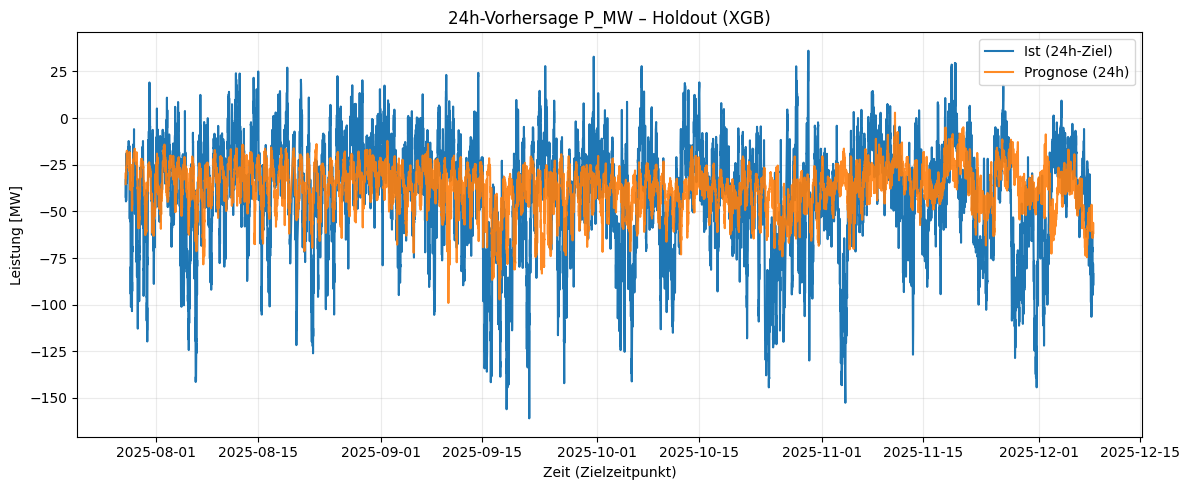


=== Zusammenfassung (Test/Holdout, 24h-Horizont) ===
Baseline: {'MAE': 26.02886061168415, 'RMSE': 33.558854321894685, 'MAPE': np.float64(353.43446856523906), 'R2': -0.2964694776092842}
RF (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 21.777581028567095, 'RMSE': 28.30608236459533, 'MAPE': np.float64(454.8239968216188), 'R2': 0.07762488585339544}
XGB (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 21.823183326915107, 'RMSE': 28.700622067324474, 'MAPE': np.float64(415.8677792657825), 'R2': 0.05173293982134397}
LSTM (best_cfg={'hidden_size': 32, 'dropout': 0.0}): {'MAE': 21.831348029711375, 'RMSE': 28.35714236090138, 'MAPE': np.float64(442.2990251975545), 'R2': 0.07386134355764773}

=== Trainingszeiten (ca.) ===
RF   (GridSearch + Fit): 335.5s
XGB  (GridSearch + Fit): 36.1s
LSTM (HPO + final Fit):  91.0s


In [ ]:
# -*- coding: utf-8 -*-
"""
Minimal-Setup:
    pip install pandas numpy scikit-learn matplotlib xgboost torch
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# ======= USER-INPUT =======
CSV_PATH = r"src\data\raw\timeseries\SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
CANDIDATE_TARGETS = ["P_MW"]

# Achtung: diese Namen müssen zu deiner CSV passen
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (Vielfache von 15 Minuten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]  # 15min, 1h, 2h, 3h, 6h, 24h

# Rolling-Window-Längen (in 15-min-Schritten) – Spaltennamen anpassen!
ROLL_WINDOWS = {
    "Windgeschw_mps": [4, 12, 24],
    "Globale_Strahlung_Wm2": [4, 12, 24],
}

# Fourier-Saisonalität (Tagesperiodik = 24h = 96 Schritte à 15min)
FOURIER_K = 3
PERIOD_STEPS = 96  # 24h

# Vorhersagehorizont: 24h = 96 * 15min
HORIZON_STEPS = 96

HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42

# LSTM-spezifisch
LSTM_LOOKBACK = 24   # 24 Schritte (= 6h bei 15min)
LSTM_EPOCHS = 15
LSTM_BATCH_SIZE = 256
LSTM_PATIENCE = 3
LEARNING_RATE = 1e-3
# ==========================

torch.manual_seed(RANDOM_STATE)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)

    target_col = None
    for c in CANDIDATE_TARGETS:
        if c in df.columns:
            target_col = c
            break
    if target_col is None:
        raise KeyError(f"Zielspalte nicht gefunden. Erwartet eine von {CANDIDATE_TARGETS}.")

    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df, target_col


def add_basic_time_features(df, ts_col):
    ts = df[ts_col]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    # Zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps, K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


def add_rolling_features(df, windows_dict):
    for col, wins in windows_dict.items():
        if col not in df.columns:
            continue
        for w in wins:
            df[f"{col}_roll{w}_mean"] = df[col].rolling(window=w, min_periods=w).mean()
            df[f"{col}_roll{w}_std"] = df[col].rolling(window=w, min_periods=w).std()
            df[f"{col}_roll{w}_min"] = df[col].rolling(window=w, min_periods=w).min()
            df[f"{col}_roll{w}_max"] = df[col].rolling(window=w, min_periods=w).max()
    return df


def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_pred, title):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (24h-Ziel)", linewidth=1.5)
    plt.plot(ts, y_pred, label="Prognose (24h)", linewidth=1.5, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt)")
    plt.ylabel("Leistung [MW]")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


# ===================== Random Forest & XGBoost =====================

def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t
    print(f"[{model_name}] Beste Parameter: {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE: {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit-Dauer: {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (24h) ")
    return scores, grid.best_params_, y_pred_test, dur


# ===================== LSTM (PyTorch) =====================

def create_lstm_dataset(series, lookback, horizon_steps):
    """
    Univariate LSTM:
    Eingabe:  [y_{t-lookback}, ..., y_{t-1}]
    Ziel:     y_{t + horizon_steps}
    """
    X, y = [], []
    n = len(series)
    # letzter gültiger Index t: t + horizon_steps < n  → t <= n - horizon_steps - 1
    for t in range(lookback, n - horizon_steps):
        X.append(series[t - lookback:t])
        y.append(series[t + horizon_steps])
    X = np.array(X)
    y = np.array(y)
    # Form: (samples, timesteps, features=1)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y


class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # letztes Zeitfenster
        out = self.dropout(out)
        out = self.fc(out)
        return out


def train_lstm_model(
    X_tr,
    y_tr,
    X_val,
    y_val,
    hidden_size,
    dropout,
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH_SIZE,
):
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(DEVICE)
    y_tr_t = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(-1).to(DEVICE)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1).to(DEVICE)

    train_ds = TensorDataset(X_tr_t, y_tr_t)
    val_ds = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = LSTMRegressor(input_size=1, hidden_size=hidden_size, dropout=dropout).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = np.inf
    best_state = None
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        # Early Stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= LSTM_PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_loss


def run_lstm(y_series, split_idx, lookback=LSTM_LOOKBACK, horizon_steps=HORIZON_STEPS):
    """
    y_series: komplette Zeitreihe (Train+Test) als 1D-Array
    split_idx: Index-Grenze Train/Test in Originalzeitreihe (wie in main)
    horizon_steps: Vorhersagehorizont in Schritten (z.B. 96 für 24h)
    """
    print("\n[LSTM] Erzeuge Sequenzdaten (24h-Horizont)...")

    X_seq, y_seq = create_lstm_dataset(y_series, lookback, horizon_steps)
    n_seq = len(y_seq)

    # Zielzeitpunkte pro Sample:
    # t_target = (lookback + i) + horizon_steps
    t_targets = np.arange(lookback, lookback + n_seq) + horizon_steps

    # Train-Samples: Zielzeitpunkt in Trainingsbereich
    train_mask = t_targets < split_idx
    test_mask = t_targets >= split_idx

    X_train_seq = X_seq[train_mask]
    y_train_seq = y_seq[train_mask]
    X_test_seq = X_seq[test_mask]
    y_test_seq = y_seq[test_mask]

    print(f"[LSTM] Seq-Train: {X_train_seq.shape}, Seq-Test: {X_test_seq.shape}")

    # 80/20 Val-Split innerhalb des Trainingsbereichs
    n_seq_train = len(X_train_seq)
    val_split_idx = int(0.8 * n_seq_train)
    X_tr, X_val = X_train_seq[:val_split_idx], X_train_seq[val_split_idx:]
    y_tr, y_val = y_train_seq[:val_split_idx], y_train_seq[val_split_idx:]

    candidate_params = [
        {"hidden_size": 32, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.2},
    ]

    best_cfg = None
    best_mae = np.inf
    total_start = time.time()

    print("[LSTM] Hyperparameter-Suche (hidden_size, dropout)...")
    for cfg in candidate_params:
        print(f"  Teste cfg={cfg} ...")
        start_t = time.time()
        model, best_val_loss = train_lstm_model(
            X_tr,
            y_tr,
            X_val,
            y_val,
            hidden_size=cfg["hidden_size"],
            dropout=cfg["dropout"],
        )
        dur = time.time() - start_t

        model.eval()
        with torch.no_grad():
            X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
            val_pred = model(X_val_t).cpu().numpy().flatten()
        mae = mean_absolute_error(y_val, val_pred)
        print(f"    -> Val-MAE={mae:.4f}, Zeit={dur:.1f}s, best_val_loss={best_val_loss:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_cfg = cfg

    print(f"[LSTM] Beste Konfiguration: {best_cfg}, Val-MAE={best_mae:.4f}")

    # Finale Anpassung auf allen Trainingssequenzen
    print("[LSTM] Finale Anpassung mit bester Konfiguration...")
    start_t = time.time()
    model, _ = train_lstm_model(
        X_train_seq,
        y_train_seq,
        X_val=X_train_seq[int(0.9 * len(X_train_seq)):],
        y_val=y_train_seq[int(0.9 * len(X_train_seq)):],
        hidden_size=best_cfg["hidden_size"],
        dropout=best_cfg["dropout"],
    )
    dur_final = time.time() - start_t
    total_dur = time.time() - total_start
    print(f"[LSTM] Trainingsdauer (final): {dur_final:.1f}s")
    print(f"[LSTM] Gesamtdauer (HPO + final): {total_dur:.1f}s")

    model.eval()
    with torch.no_grad():
        X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(DEVICE)
        y_pred_test_seq = model(X_test_t).cpu().numpy().flatten()

    scores = evaluate(y_test_seq, y_pred_test_seq, prefix="LSTM TST (24h) ")
    return scores, best_cfg, y_pred_test_seq, total_dur


# ===================== MAIN =====================

def main():
    df, target_col = load_data(CSV_PATH)

    # Basis-Zeitfeatures + Fourier
    df = add_basic_time_features(df, TIMESTAMP_COL)
    df = add_fourier_features(df, PERIOD_STEPS, FOURIER_K, prefix="day")

    # Zielzeitpunkt (24h später) für Plot/Interpretation
    df["timestamp_target"] = df[TIMESTAMP_COL] + pd.to_timedelta(15 * HORIZON_STEPS, unit="m")

    # Verfügbare Rohfeatures prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing:
        print(f"Warnung: fehlen im Datensatz und werden ignoriert: {missing}")

    df = add_rolling_features(df, ROLL_WINDOWS)
    df = add_target_lags(df, target_col, TARGET_LAGS)

    base_time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{target_col}_lag{l}" for l in TARGET_LAGS]
    roll_feats = [c for c in df.columns
                  if any(c.startswith(f"{f}_roll") for f in ROLL_WINDOWS.keys())]

    X_cols = present_feats + base_time_feats + fourier_feats + lag_feats + roll_feats

    # Ziel: P in 24h (HORIZON_STEPS)
    # target_24 ist der Wert HORIZON_STEPS Schritte in der Zukunft
    df["target_24"] = df[target_col].shift(-HORIZON_STEPS)

    # Drop Zeilen ohne vollständige Features/Ziel
    df_model = df.dropna(subset=X_cols + ["target_24", target_col]).copy()

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)
    X = df_model[X_cols]
    y = df_model["target_24"]

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test (Holdout): {len(X_test)}")
    print(f"Vorhersagehorizont: {HORIZON_STEPS} Schritte = 24h")

    # ===== Baseline (Naive 24h-Persistence: y_hat_{t+24h} = y_t) =====
    print("\nBaseline (Naive 24h-Persistence) – Scores:")
    y_train_baseline = df_model[target_col].iloc[:split_idx].values
    y_test_baseline = df_model[target_col].iloc[split_idx:].values
    _ = evaluate(y_train.values, y_train_baseline, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_test_baseline, prefix="BL  (Test)  ")

    # ===== Random Forest =====
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== XGBoost =====
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== LSTM (PyTorch) =====
    # komplette Serie für LSTM
    y_series = df_model[target_col].values
    lstm_scores, lstm_best_cfg, lstm_pred, lstm_time = run_lstm(
        y_series,
        split_idx,
        lookback=LSTM_LOOKBACK,
        horizon_steps=HORIZON_STEPS,
    )

    # ===== Plot beispielhaft (Holdout: XGB vs Ist, 24h-Ziel) =====
    ts_holdout = df_model["timestamp_target"].iloc[split_idx:]
    plot_holdout(ts_holdout, y_test.values, xgb_pred, title=f"24h-Vorhersage {target_col} – Holdout (XGB)")

    print("\n=== Zusammenfassung (Test/Holdout, 24h-Horizont) ===")
    print("Baseline:", bl_scores)
    print(f"RF (best_params={rf_best_params}):", rf_scores)
    print(f"XGB (best_params={xgb_best_params}):", xgb_scores)
    print(f"LSTM (best_cfg={lstm_best_cfg}):", lstm_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF   (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB  (GridSearch + Fit): {xgb_time:.1f}s")
    print(f"LSTM (HPO + final Fit):  {lstm_time:.1f}s")


if __name__ == "__main__":
    main()


Lade Daten...
Datengrößen – Gesamt: 64306, Train: 51444, Test: 12862
Vorhersagehorizont: t+1 (15 Minuten)

Baseline (Naive One-Step-Persistence) – Scores:
BL  (Train) MAE:  5.7304
BL  (Train) RMSE: 9.6202
BL  (Train) MAPE: 46,446.11%
BL  (Train) R²:   0.8907
BL  (Test)  MAE:  9.7404
BL  (Test)  RMSE: 12.5984
BL  (Test)  MAPE: 116.13%
BL  (Test)  R²:   0.8169

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[RF] Beste Parameter  : {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE     : 6.1023
[RF] GridSearch+Fit(s): 355.6s
RF TST (t+1) MAE:  9.6028
RF TST (t+1) RMSE: 12.3535
RF TST (t+1) MAPE: 138.99%
RF TST (t+1) R²:   0.8240

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter  : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE     : 6.1455
[XGB] GridSearch+Fit(s): 18.0s
XGB TST (t+1) MAE:  9.4643
XGB TST (t+1) RMSE: 12.2191
XGB TST (t+1) MAPE: 135.44%
XGB TST (t+1) R²:   0.8278


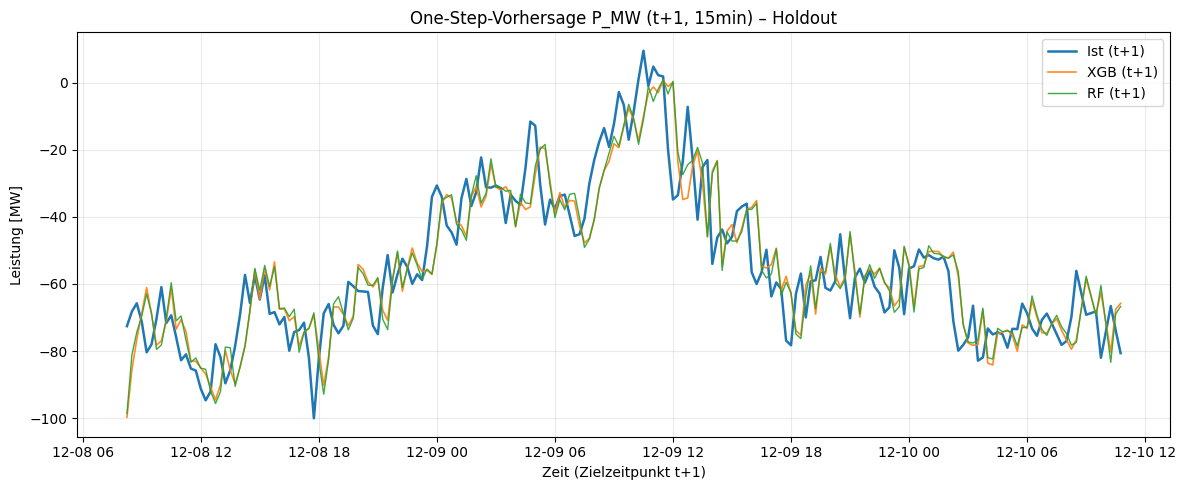


=== Zusammenfassung (Test/Holdout, t+1) ===
Baseline: {'MAE': 9.74040401467693, 'RMSE': 12.59837433807279, 'MAPE': np.float64(116.12662289556643), 'R2': 0.816914150718382}
RF   (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 9.60278838132388, 'RMSE': 12.353490366716896, 'MAPE': np.float64(138.99378369683825), 'R2': 0.8239625277712702}
XGB  (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 9.464323282503093, 'RMSE': 12.219134805111967, 'MAPE': np.float64(135.43634164090622), 'R2': 0.8277708436770632}

=== Trainingszeiten (ca.) ===
RF  (GridSearch + Fit): 355.6s
XGB (GridSearch + Fit): 18.0s


In [9]:
# -*- coding: utf-8 -*-
"""
One-Step-Forecast (t+1, 15 Minuten)
Modelle: RandomForest, XGBoost
Mit Hyperparameter-Tuning via GridSearchCV + TimeSeriesSplit

Benötigte Pakete:
    pip install pandas numpy scikit-learn matplotlib xgboost
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===================== USER SETTINGS =====================
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Wetter-/Exogene Features (müssen in der CSV existieren)
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (in 15-Min-Schritten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier-Saisonalität (Tagesperiodik, 24h = 96 * 15min)
FOURIER_K = 3
PERIOD_STEPS = 96

# Train/Test-Split
HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# =========================================================


# =========================================================
# Utility / Evaluation
# =========================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_rf, y_xgb, title="One-Step-Forecast (t+1, 15min)"):
    """Plot Ausschnitt des Holdouts (z.B. letzte 200 Punkte)."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (t+1)", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB (t+1)", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF (t+1)", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt t+1)")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================================================
# Feature Engineering
# =========================================================
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    if TARGET not in df.columns:
        raise KeyError(f"Zielspalte '{TARGET}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df


def add_time_features(df):
    ts = df[TIMESTAMP_COL]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    # zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


# =========================================================
# Baum-Modelle mit GridSearch
# =========================================================
def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t

    print(f"[{model_name}] Beste Parameter  : {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE     : {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit(s): {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (t+1) ")
    return scores, grid.best_params_, y_pred_test, dur


# =========================================================
# MAIN
# =========================================================
def main():
    print("Lade Daten...")
    df = load_data(CSV_PATH)

    # ========== Feature Engineering ==========
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # Ziel: t+1 (ein Schritt = 15 Minuten)
    df["target_1"] = df[TARGET].shift(-1)

    # Verfügbare exogene Features prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing_feats = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing_feats:
        print(f"Warnung: folgende RAW_FEATURES fehlen und werden ignoriert: {missing_feats}")

    time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{TARGET}_lag{l}" for l in TARGET_LAGS]

    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    # NaNs entfernen (wegen Shifts)
    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()

    X = df_model[feature_cols]
    y = df_model["target_1"]

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test: {len(X_test)}")
    print("Vorhersagehorizont: t+1 (15 Minuten)")

    # ========== Baseline (Naive Persistence: y_hat_{t+1} = y_t) ==========
    print("\nBaseline (Naive One-Step-Persistence) – Scores:")
    # Baseline nutzt einfach lag1 als Vorhersage
    y_baseline_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    y_baseline_test = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values

    _ = evaluate(y_train.values, y_baseline_train, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_baseline_test, prefix="BL  (Test)  ")

    # ========== Random Forest ==========
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== XGBoost ==========
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== Plot – Ausschnitt Holdout ==========
    # z.B. letzte 200 Punkte
    n_plot = 200
    if len(y_test) <= n_plot:
        start_idx = 0
    else:
        start_idx = len(y_test) - n_plot

    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(
        ts_holdout.iloc[start_idx:],
        y_test.values[start_idx:],
        rf_pred[start_idx:],
        xgb_pred[start_idx:],
        title=f"One-Step-Vorhersage {TARGET} (t+1, 15min) – Holdout"
    )

    print("\n=== Zusammenfassung (Test/Holdout, t+1) ===")
    print("Baseline:", bl_scores)
    print(f"RF   (best_params={rf_best_params}):", rf_scores)
    print(f"XGB  (best_params={xgb_best_params}):", xgb_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF  (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB (GridSearch + Fit): {xgb_time:.1f}s")


if __name__ == "__main__":
    main()


=== Kopf des Datensatzes ===
            timestamp       P_MW  temperature_C  wind_speed_mps  \
0 2024-01-01 00:00:00 -22.996800            NaN             NaN   
1 2024-01-01 00:15:00 -23.516007            NaN             NaN   
2 2024-01-01 00:30:00 -23.192500            NaN             NaN   
3 2024-01-01 00:45:00 -22.885967            NaN             NaN   
4 2024-01-01 01:00:00 -24.715713            6.6            17.7   

   solar_radiation_Wm2  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  0.0  

=== Spalten & Datentypen ===
timestamp              datetime64[ns]
P_MW                          float64
temperature_C                 float64
wind_speed_mps                float64
solar_radiation_Wm2           float64
dtype: object

=== Anzahl Zeilen & Zeitraum ===
Zeilen: 68116
Von: 2024-01-01 00:00:00
Bis: 2025-12-10 12:45:00

=== Sampling-Intervall (häufigste Differenz) ===
timestamp
0 days 00:15:00    68115
N

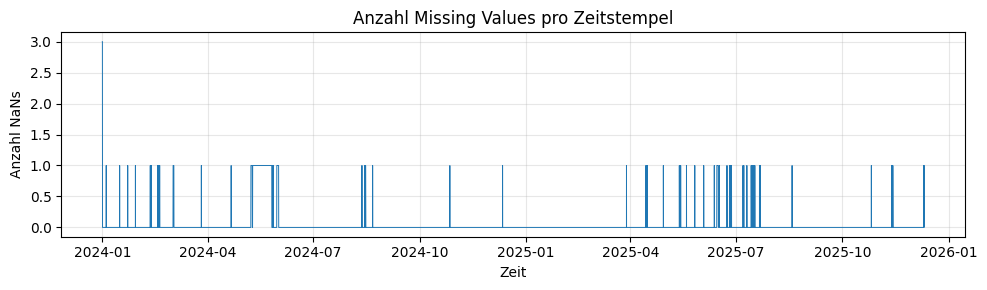

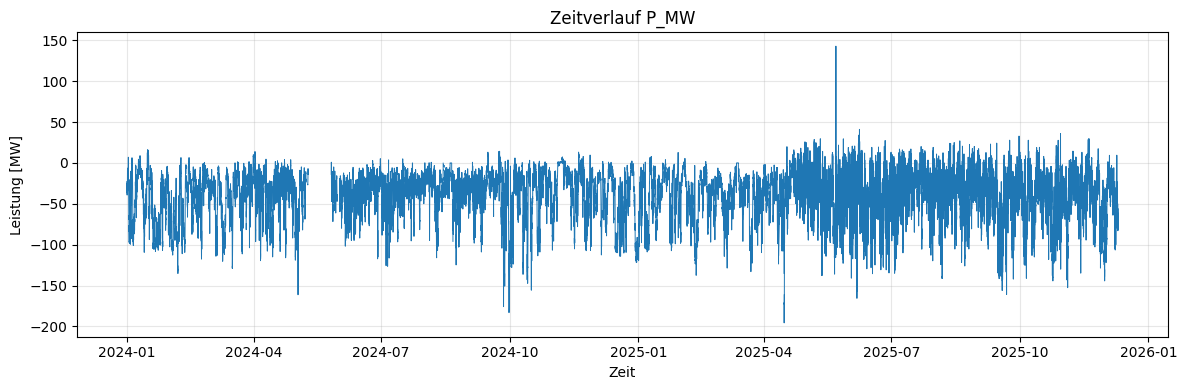

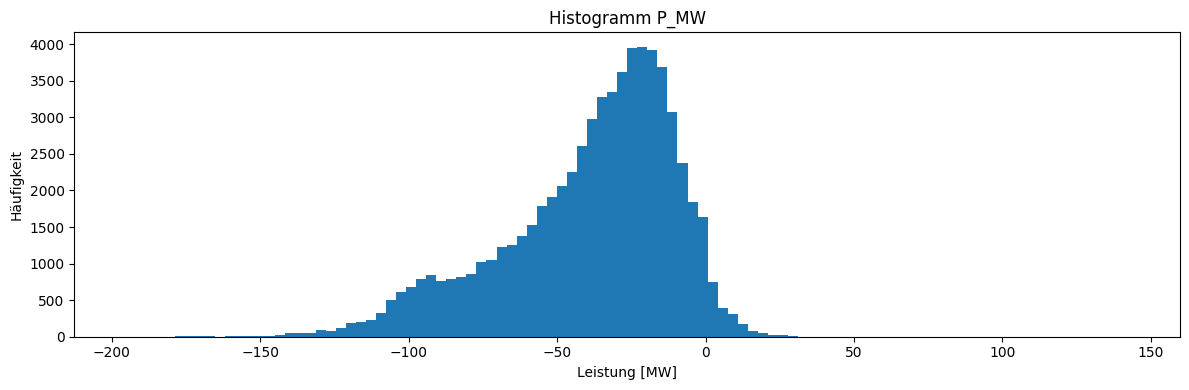


=== Zielvariable – mögliche Ausreißer/Probleme ===
Min: -195.637, Max: 142.891
Quantile 0.1%, 1%, 99%, 99.9%:
0.001   -151.726231
0.010   -119.238984
0.990      7.648999
0.999     21.496507
Name: P_MW, dtype: float64

Anteil negativer Werte: 93.10%
Anteil exakt 0:         0.31%


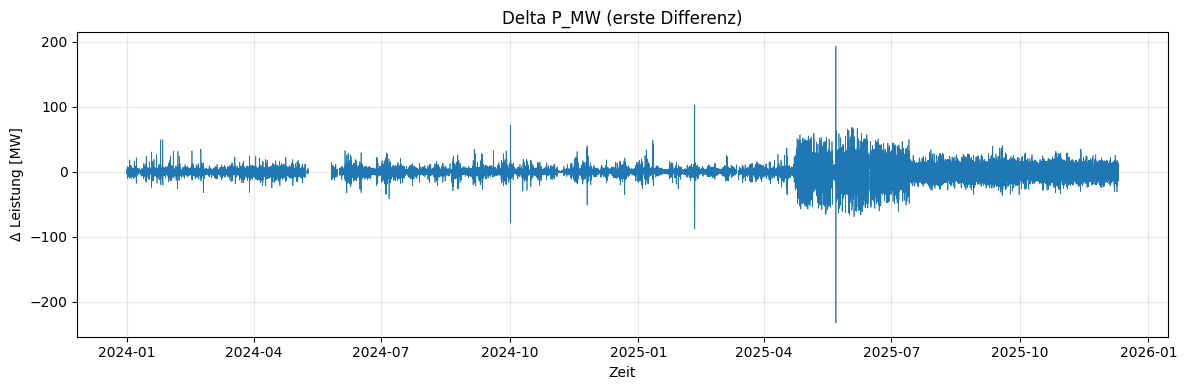


=== Extrem große Änderungen (Delta) ===
count    65676.000000
mean        -0.001335
std          7.862691
min       -232.089647
25%         -2.247251
50%          0.006716
75%          2.338882
max        192.872573
Name: P_diff, dtype: float64

=== Train/Test Zeitraum ===
Train:  2024-01-01 00:00:00 → 2025-07-21 14:45:00
Test:   2025-07-21 15:00:00 → 2025-12-10 12:45:00

=== Vergleich Train/Test Verteilung für P_MW ===


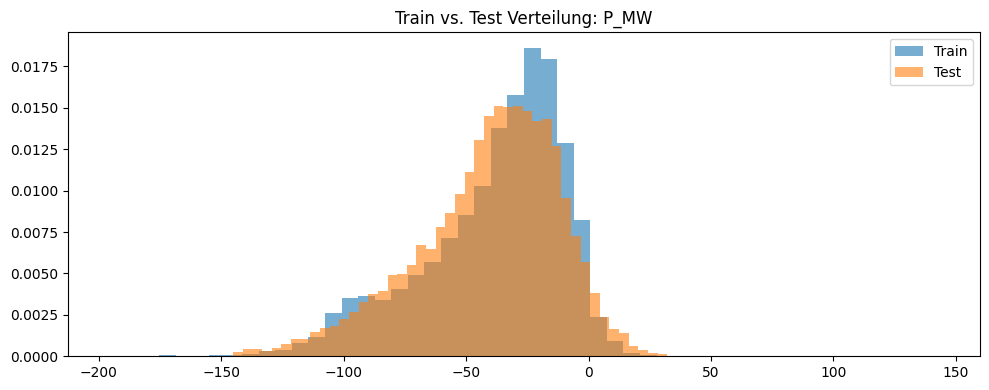


=== Vergleich Train/Test Verteilung für wind_speed_mps ===


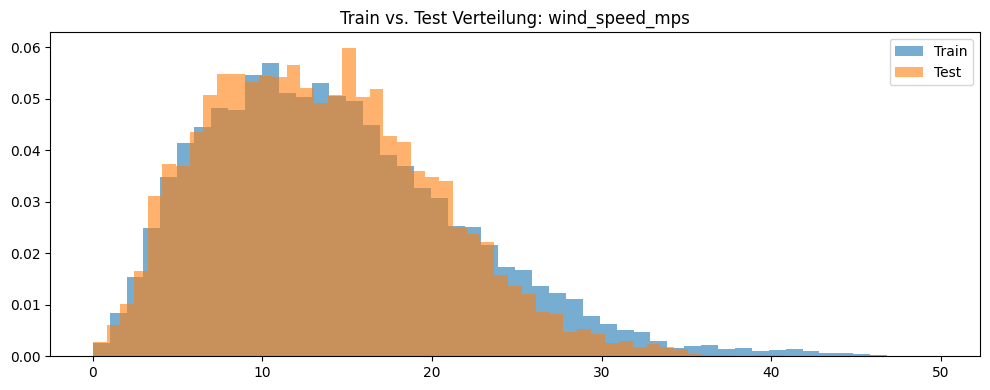


=== Vergleich Train/Test Verteilung für solar_radiation_Wm2 ===


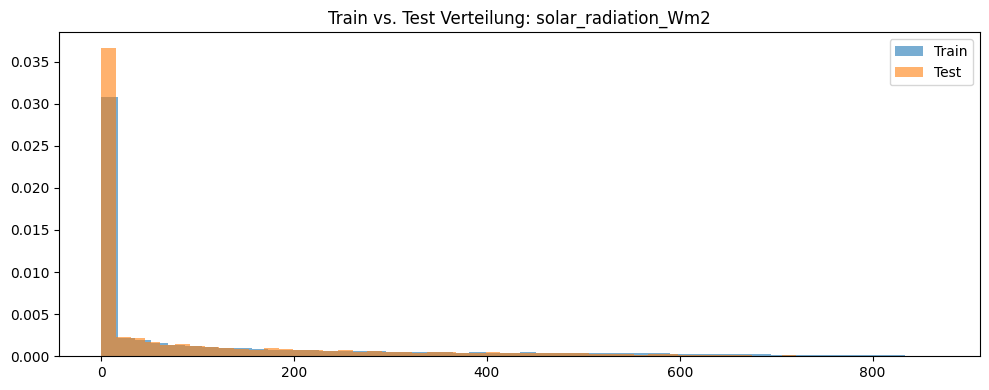


=== Vergleich Train/Test Verteilung für temperature_C ===


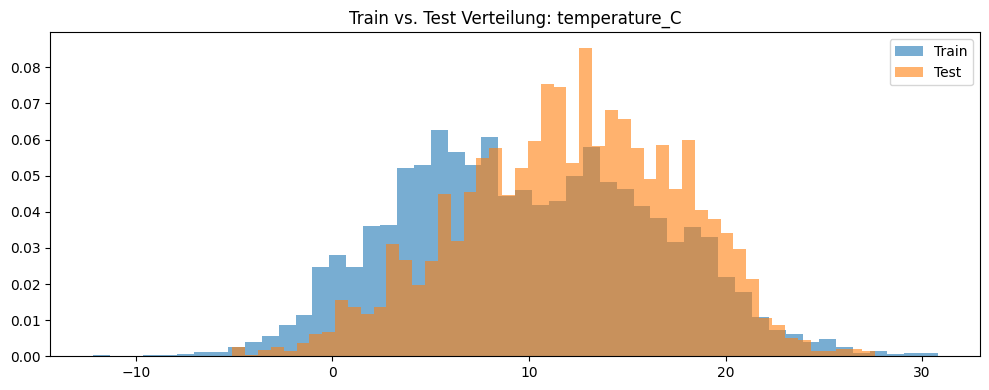


=== Korrelationsmatrix (P_MW & Wetter) ===
                      P_MW  wind_speed_mps  solar_radiation_Wm2  temperature_C
P_MW                 1.000          -0.777               -0.148         -0.045
wind_speed_mps      -0.777           1.000                0.153          0.046
solar_radiation_Wm2 -0.148           0.153                1.000          0.525
temperature_C       -0.045           0.046                0.525          1.000


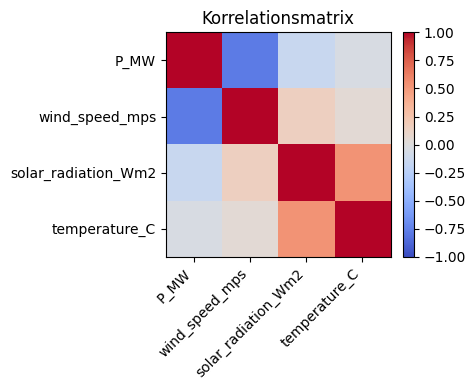

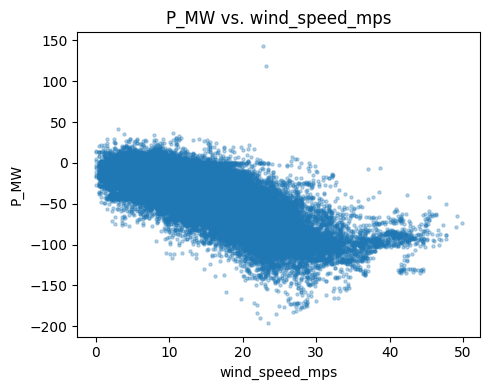

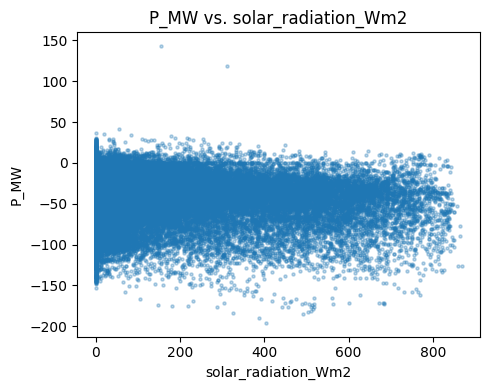

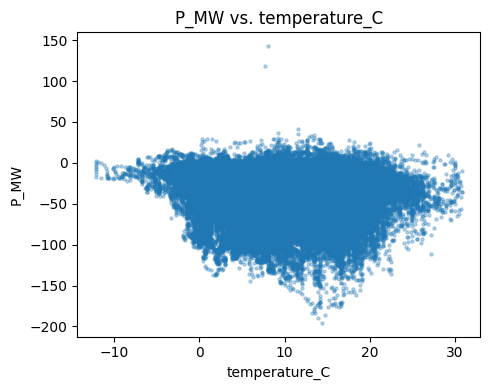

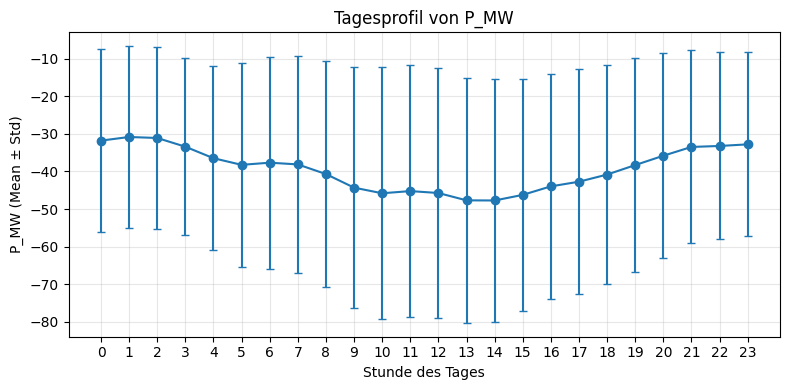

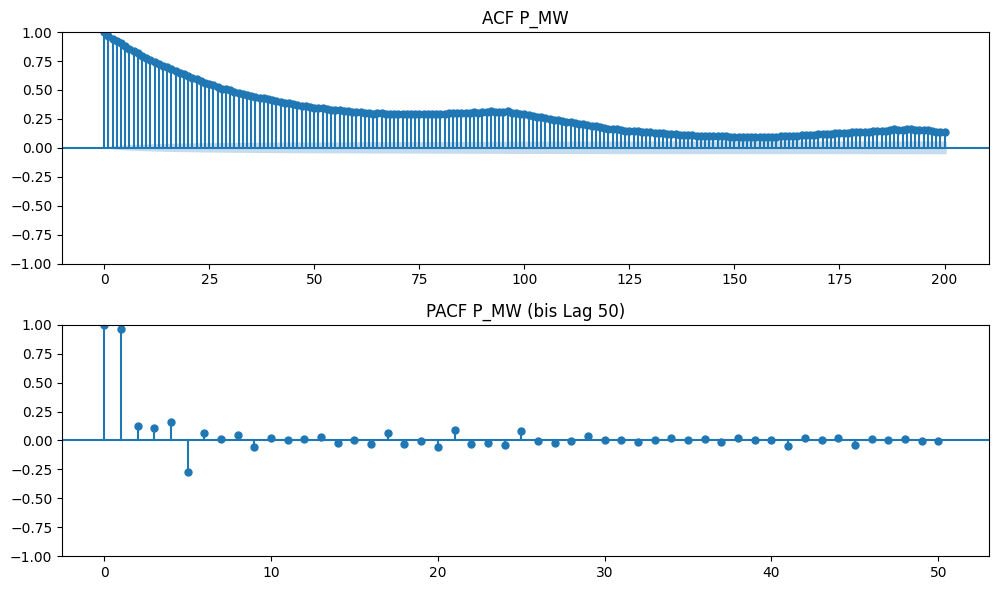


=== Hinweise zur Interpretation (manuell prüfen) ===
- Sind viele Missing Values oder ganze Zeitblöcke leer?
- Sind starke Ausreißer (sehr hohe oder negative P_MW) sichtbar?
- Gibt es deutliche Verteilungsunterschiede zwischen Train und Test?
- Sind Zusammenhänge P_MW ~ Wetter (Wind, Strahlung, Temperatur) erkennbar?
- Ist das Tagesprofil plausibel (z.B. typische Lastverläufe)?
- Deuten ACF/PACF auf starke Trends/Periodizität hin, die Modelle schwer abdecken?


In [11]:
# %% EDA für Zeitreihen-Prognose-Datensatz (P_MW + Wetter)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter

# Optional: Statsmodels für ACF/PACF, falls installiert
try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    print("Hinweis: statsmodels nicht installiert – ACF/PACF werden übersprungen.")

# ======= USER-INPUT =======
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
            
TIMESTAMP_COL = "timestamp"
TARGET_COL = "P_MW"
WEATHER_COLS = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]
# ==========================

# ------------------ 1. Laden & Basischecks ------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV nicht gefunden: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

if TIMESTAMP_COL not in df.columns:
    raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt im Datensatz.")

df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)

print("=== Kopf des Datensatzes ===")
print(df.head())
print("\n=== Spalten & Datentypen ===")
print(df.dtypes)

print("\n=== Anzahl Zeilen & Zeitraum ===")
print("Zeilen:", len(df))
print("Von:", df[TIMESTAMP_COL].min())
print("Bis:", df[TIMESTAMP_COL].max())

# Sampling-Intervall grob prüfen
dt = df[TIMESTAMP_COL].diff().dropna()
print("\n=== Sampling-Intervall (häufigste Differenz) ===")
print(dt.value_counts().head())

# ------------------ 2. Missing Values & Basisstatistik ------------------
print("\n=== Missing Values pro Spalte (Anteil in %) ===")
na_frac = df.isna().mean() * 100
print(na_frac.sort_values(ascending=False).round(2))

print("\n=== Deskriptive Statistik (numerische Spalten) ===")
print(df.describe().T)

# Verlauf Missing Values über die Zeit (nur Info, kein Muss)
plt.figure(figsize=(10,3))
plt.plot(df[TIMESTAMP_COL], df.isna().sum(axis=1), linewidth=0.7)
plt.title("Anzahl Missing Values pro Zeitstempel")
plt.xlabel("Zeit")
plt.ylabel("Anzahl NaNs")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------ 3. Zielvariable P_MW: Verteilung & Ausreißer ------------------
if TARGET_COL not in df.columns:
    raise KeyError(f"TARGET_COL '{TARGET_COL}' nicht im Datensatz.")

plt.figure(figsize=(12,4))
plt.plot(df[TIMESTAMP_COL], df[TARGET_COL], linewidth=0.7)
plt.title(f"Zeitverlauf {TARGET_COL}")
plt.xlabel("Zeit")
plt.ylabel("Leistung [MW]")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(df[TARGET_COL].dropna(), bins=100)
plt.title(f"Histogramm {TARGET_COL}")
plt.xlabel("Leistung [MW]")
plt.ylabel("Häufigkeit")
plt.tight_layout()
plt.show()

print("\n=== Zielvariable – mögliche Ausreißer/Probleme ===")
print(f"Min: {df[TARGET_COL].min():.3f}, Max: {df[TARGET_COL].max():.3f}")
q = df[TARGET_COL].quantile([0.001, 0.01, 0.99, 0.999])
print("Quantile 0.1%, 1%, 99%, 99.9%:")
print(q)

# Negative Werte / genau 0 / sehr große Werte
neg_share = (df[TARGET_COL] < 0).mean() * 100
zero_share = (df[TARGET_COL] == 0).mean() * 100
print(f"\nAnteil negativer Werte: {neg_share:.2f}%")
print(f"Anteil exakt 0:         {zero_share:.2f}%")

# Sprunghafte Änderungen
df["P_diff"] = df[TARGET_COL].diff()
plt.figure(figsize=(12,4))
plt.plot(df[TIMESTAMP_COL], df["P_diff"], linewidth=0.5)
plt.title(f"Delta {TARGET_COL} (erste Differenz)")
plt.xlabel("Zeit")
plt.ylabel("Δ Leistung [MW]")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=== Extrem große Änderungen (Delta) ===")
print(df["P_diff"].describe())

# ------------------ 4. Train/Test-Shift grob prüfen ------------------
n = len(df)
split_idx = int(n * (1 - 0.2))  # analog HOLDOUT_FRAC = 0.2
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

print("\n=== Train/Test Zeitraum ===")
print("Train: ", df_train[TIMESTAMP_COL].min(), "→", df_train[TIMESTAMP_COL].max())
print("Test:  ", df_test[TIMESTAMP_COL].min(), "→", df_test[TIMESTAMP_COL].max())

def compare_train_test_distribution(series_name):
    if series_name not in df.columns:
        print(f"[Skip] {series_name} nicht im Datensatz.")
        return
    plt.figure(figsize=(10,4))
    plt.hist(df_train[series_name].dropna(), bins=50, alpha=0.6, label="Train", density=True)
    plt.hist(df_test[series_name].dropna(), bins=50, alpha=0.6, label="Test", density=True)
    plt.title(f"Train vs. Test Verteilung: {series_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n=== Vergleich Train/Test Verteilung für P_MW ===")
compare_train_test_distribution(TARGET_COL)

for col in WEATHER_COLS:
    print(f"\n=== Vergleich Train/Test Verteilung für {col} ===")
    compare_train_test_distribution(col)

# ------------------ 5. Korrelationen mit Wetter ------------------
num_cols = [c for c in [TARGET_COL] + WEATHER_COLS if c in df.columns]
corr = df[num_cols].corr()

print("\n=== Korrelationsmatrix (P_MW & Wetter) ===")
print(corr.round(3))

plt.figure(figsize=(5,4))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Korrelationsmatrix")
plt.tight_layout()
plt.show()

# Scatterplots P_MW vs. Wetter
for col in WEATHER_COLS:
    if col not in df.columns:
        continue
    plt.figure(figsize=(5,4))
    plt.scatter(df[col], df[TARGET_COL], s=5, alpha=0.3)
    plt.xlabel(col)
    plt.ylabel(TARGET_COL)
    plt.title(f"{TARGET_COL} vs. {col}")
    plt.tight_layout()
    plt.show()

# ------------------ 6. Saisonalität & Autokorrelation ------------------
# Tagesmuster (auf Stunden gemittelt)
df["hour"] = df[TIMESTAMP_COL].dt.hour
hourly_profile = df.groupby("hour")[TARGET_COL].agg(["mean", "std"])

plt.figure(figsize=(8,4))
plt.errorbar(hourly_profile.index, hourly_profile["mean"],
             yerr=hourly_profile["std"], fmt="-o", capsize=3)
plt.xticks(range(0,24))
plt.xlabel("Stunde des Tages")
plt.ylabel("P_MW (Mean ± Std)")
plt.title("Tagesprofil von P_MW")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: ACF/PACF
if HAS_STATSMODELS:
    # ggf. Serie auf einen kürzeren Zeitraum beschränken (z.B. letztes Jahr),
    # um Plot lesbarer zu halten:
    series = df[TARGET_COL].dropna()
    max_lag = 200  # 200*15min ≈ 50h

    fig, axes = plt.subplots(2, 1, figsize=(10,6))
    plot_acf(series, lags=max_lag, ax=axes[0])
    axes[0].set_title("ACF P_MW")
    plot_pacf(series, lags=50, ax=axes[1])
    axes[1].set_title("PACF P_MW (bis Lag 50)")
    plt.tight_layout()
    plt.show()
else:
    print("\nACF/PACF übersprungen (statsmodels nicht installiert).")

# ------------------ 7. Kurze Interpretation-Hinweise ------------------
print("\n=== Hinweise zur Interpretation (manuell prüfen) ===")
print("- Sind viele Missing Values oder ganze Zeitblöcke leer?")
print("- Sind starke Ausreißer (sehr hohe oder negative P_MW) sichtbar?")
print("- Gibt es deutliche Verteilungsunterschiede zwischen Train und Test?")
print("- Sind Zusammenhänge P_MW ~ Wetter (Wind, Strahlung, Temperatur) erkennbar?")
print("- Ist das Tagesprofil plausibel (z.B. typische Lastverläufe)?")
print("- Deuten ACF/PACF auf starke Trends/Periodizität hin, die Modelle schwer abdecken?")


Lade Daten...
Datengrößen – Gesamt: 64306, Train: 51444, Test: 12862
Vorhersagehorizont: t+1 (15 Minuten)

Baseline (Naive One-Step-Persistence) – Scores:
BL  (Train) MAE:  5.7304
BL  (Train) RMSE: 9.6202
BL  (Train) MAPE: 46,446.11%
BL  (Train) R²:   0.8907
BL  (Test)  MAE:  9.7404
BL  (Test)  RMSE: 12.5984
BL  (Test)  MAPE: 116.13%
BL  (Test)  R²:   0.8169

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[RF] Beste Parameter  : {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE     : 6.1023
[RF] GridSearch+Fit(s): 348.5s
RF TST (t+1) MAE:  9.6028
RF TST (t+1) RMSE: 12.3535
RF TST (t+1) MAPE: 138.99%
RF TST (t+1) R²:   0.8240

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter  : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE     : 6.1455
[XGB] GridSearch+Fit(s): 18.9s
XGB TST (t+1) MAE:  9.4643
XGB TST (t+1) RMSE: 12.2191
XGB TST (t+1) MAPE: 135.44%
XGB TST (t+1) R²:   0.8278


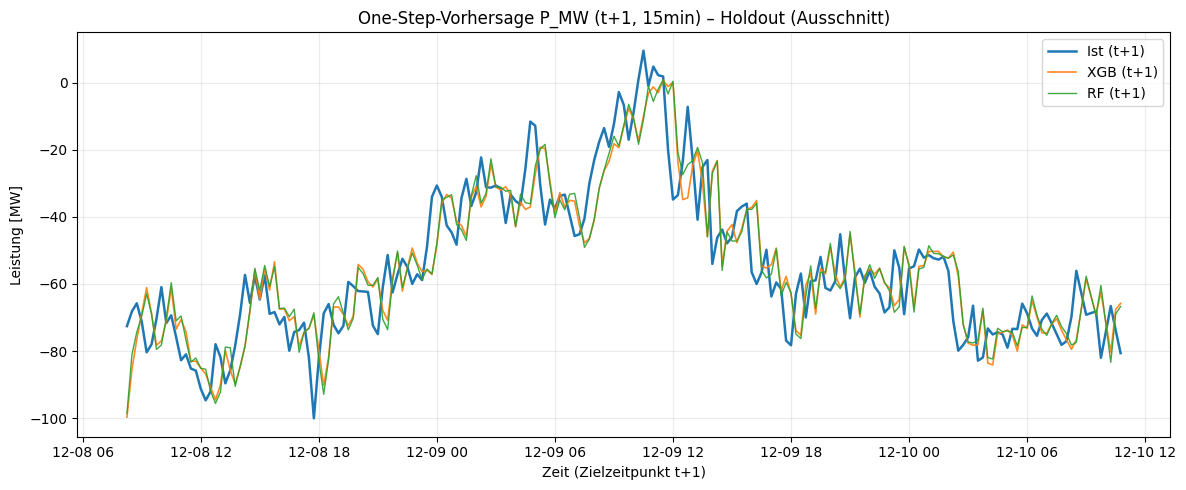


=== Zusammenfassung (Test/Holdout, t+1) ===
Baseline: {'MAE': 9.74040401467693, 'RMSE': 12.59837433807279, 'MAPE': np.float64(116.12662289556643), 'R2': 0.816914150718382}
RF   (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 9.60278838132388, 'RMSE': 12.353490366716896, 'MAPE': np.float64(138.99378369683825), 'R2': 0.8239625277712702}
XGB  (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 9.464323282503093, 'RMSE': 12.219134805111967, 'MAPE': np.float64(135.43634164090622), 'R2': 0.8277708436770632}

=== Trainingszeiten (ca.) ===
RF  (GridSearch + Fit): 348.5s
XGB (GridSearch + Fit): 18.9s

[XGB] Rekursiver Multi-Step-Forecast über 96 Schritte (24h)...

[XGB] 96-Step-Ergebnis (rekursiv):
XGB 96-Step MAE:  16.9471
XGB 96-Step RMSE: 22.4797
XGB 96-Step MAPE: 37.39%
XGB 96-Step R²:   0.2871


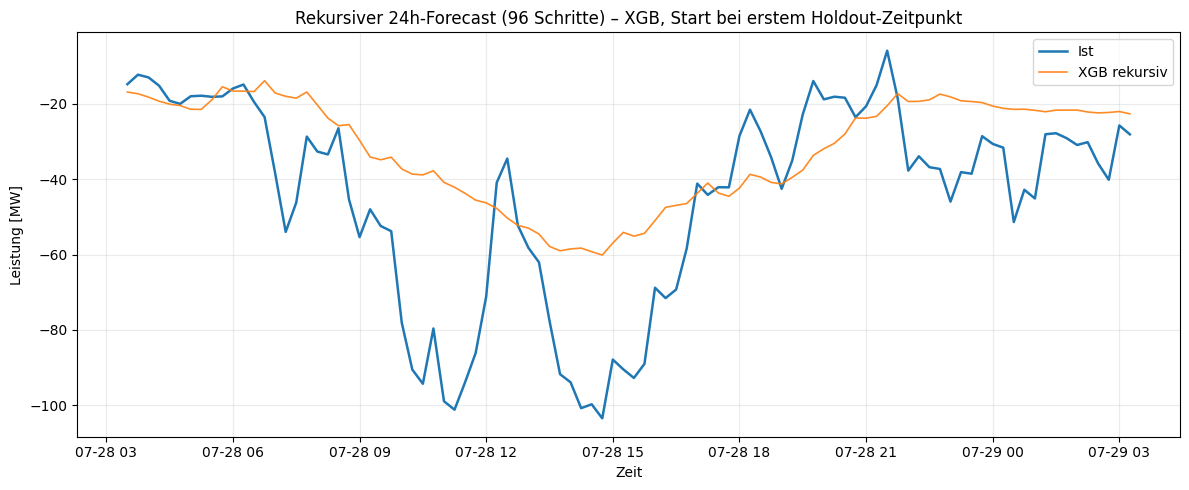

In [12]:
# 96 steps recursive forecast
# -*- coding: utf-8 -*-
"""
One-Step-Forecast (t+1, 15 Minuten) + rekursiver 96-Step-Forecast
Modelle: RandomForest, XGBoost
Mit Hyperparameter-Tuning via GridSearchCV + TimeSeriesSplit

Benötigte Pakete:
    pip install pandas numpy scikit-learn matplotlib xgboost
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===================== USER SETTINGS =====================
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Wetter-/Exogene Features (müssen in der CSV existieren)
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (in 15-Min-Schritten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier-Saisonalität (Tagesperiodik, 24h = 96 * 15min)
FOURIER_K = 3
PERIOD_STEPS = 96

# Rekursiver Forecast-Horizont
HORIZON_STEPS = 96  # 24h = 96 * 15min

# Train/Test-Split
HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# =========================================================


# =========================================================
# Utility / Evaluation
# =========================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_rf, y_xgb, title="One-Step-Forecast (t+1, 15min)"):
    """Plot Ausschnitt des Holdouts (z.B. letzte 200 Punkte)."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (t+1)", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB (t+1)", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF (t+1)", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt t+1)")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_recursive(ts, y_true, y_pred, title="Rekursiver 96-Step-Forecast (24h)"):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.8)
    plt.plot(ts, y_pred, label="XGB rekursiv", linewidth=1.2, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================================================
# Feature Engineering
# =========================================================
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    if TARGET not in df.columns:
        raise KeyError(f"Zielspalte '{TARGET}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df


def add_time_features(df):
    ts = df[TIMESTAMP_COL]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    # zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


# =========================================================
# Baum-Modelle mit GridSearch
# =========================================================
def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t

    print(f"[{model_name}] Beste Parameter  : {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE     : {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit(s): {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (t+1) ")
    return scores, grid.best_params_, y_pred_test, dur, best_model


# =========================================================
# Rekursiver Forecast mit XGBoost (t+1 ... t+96)
# =========================================================
def recursive_forecast_xgb(
    model,
    df_model,
    feature_cols,
    target_col,
    start_row_idx,
    horizon_steps,
    target_lags,
):
    """
    Rekursiver Forecast:
    - model: trainierter XGBRegressor (t+1)
    - df_model: vollständiger Modell-DataFrame (mit Zeit-/Fourier-Features, aber Lags werden überschrieben)
    - feature_cols: verwendete Feature-Spalten
    - target_col: Name des Ziel-Columns (z.B. "P_MW")
    - start_row_idx: Index der ersten Feature-Zeile im Holdout (entspricht erstem One-Step-Punkt)
    - horizon_steps: Anzahl Vorwärtsschritte (z.B. 96)
    - target_lags: Liste der Lags in Schritten (z.B. [1,4,8,12,24,96])

    Idee:
    - Für Schritt s verwenden wir die exogenen/time-Features aus Zeile (start_row_idx + s),
      überschreiben aber die Lag-Features aus einer History der letzten max_lag Zielwerte.
    - Die History enthält zu Beginn nur echte Werte, danach gemischt echt+vorhergesagt.
    - Für jedes Lag L gilt: target_lagL = history[-L]
    """
    max_lag = max(target_lags)

    # Sicherstellen, dass genug Historie vorliegt
    if start_row_idx - max_lag < 0:
        raise ValueError(
            f"start_row_idx={start_row_idx} ist zu klein für max_lag={max_lag}."
        )

    # Historie: letzte max_lag echte Zielwerte vor dem ersten Label-Zeitpunkt
    # Row k hat Label P[k+1], deshalb nehmen wir P[k-max_lag+1 .. k] als Vergangenheit.
    history = df_model[target_col].iloc[
        start_row_idx - max_lag + 1 : start_row_idx + 1
    ].tolist()
    if len(history) != max_lag:
        raise RuntimeError("History-Länge ungleich max_lag – Indexing-Problem.")

    preds = []
    label_indices = []

    for s in range(horizon_steps):
        row_idx = start_row_idx + s       # Feature-Zeile
        label_idx = row_idx + 1           # dazugehöriger Ziel-Zeitpunkt

        if label_idx >= len(df_model):
            # wir sind am Ende des verfügbaren DataFrames
            break

        # Basis-Row (Zeit, Fourier, exogene Features wie im Datensatz)
        row = df_model.iloc[row_idx].copy()

        # Lag-Features aus aktueller Historie neu setzen
        for L in target_lags:
            row[f"{target_col}_lag{L}"] = history[-L]

        x_vec = row[feature_cols].values.reshape(1, -1)
        y_hat = model.predict(x_vec)[0]

        preds.append(y_hat)
        label_indices.append(label_idx)

        # History updaten: neuen Wert anhängen, nur letzte max_lag behalten
        history.append(y_hat)
        if len(history) > max_lag:
            history = history[-max_lag:]

    return np.array(preds), np.array(label_indices)


# =========================================================
# MAIN
# =========================================================
def main():
    print("Lade Daten...")
    df = load_data(CSV_PATH)

    # ========== Feature Engineering ==========
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # Ziel: t+1 (ein Schritt = 15 Minuten)
    df["target_1"] = df[TARGET].shift(-1)

    # Verfügbare exogene Features prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing_feats = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing_feats:
        print(f"Warnung: folgende RAW_FEATURES fehlen und werden ignoriert: {missing_feats}")

    time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{TARGET}_lag{l}" for l in TARGET_LAGS]

    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    # NaNs entfernen (wegen Shifts)
    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()

    X = df_model[feature_cols]
    y = df_model["target_1"]

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test: {len(X_test)}")
    print("Vorhersagehorizont: t+1 (15 Minuten)")

    # ========== Baseline (Naive Persistence: y_hat_{t+1} = y_t) ==========
    print("\nBaseline (Naive One-Step-Persistence) – Scores:")
    # Baseline nutzt einfach lag1 als Vorhersage
    y_baseline_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    y_baseline_test = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values

    _ = evaluate(y_train.values, y_baseline_train, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_baseline_test, prefix="BL  (Test)  ")

    # ========== Random Forest ==========
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time, rf_model = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== XGBoost ==========
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time, xgb_model = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== Plot – One-Step Holdout-Ausschnitt ==========
    n_plot = 200
    if len(y_test) <= n_plot:
        start_idx_plot = 0
    else:
        start_idx_plot = len(y_test) - n_plot

    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(
        ts_holdout.iloc[start_idx_plot:],
        y_test.values[start_idx_plot:],
        rf_pred[start_idx_plot:],
        xgb_pred[start_idx_plot:],
        title=f"One-Step-Vorhersage {TARGET} (t+1, 15min) – Holdout (Ausschnitt)"
    )

    print("\n=== Zusammenfassung (Test/Holdout, t+1) ===")
    print("Baseline:", bl_scores)
    print(f"RF   (best_params={rf_best_params}):", rf_scores)
    print(f"XGB  (best_params={xgb_best_params}):", xgb_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF  (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB (GridSearch + Fit): {xgb_time:.1f}s")

    # ========== Rekursiver 96-Step-Forecast mit XGB ==========
    print(f"\n[XGB] Rekursiver Multi-Step-Forecast über {HORIZON_STEPS} Schritte (24h)...")

    # Start des rekursiven Forecasts: erste Zeile im Holdout (wie bei One-Step)
    start_row_idx = split_idx

    horizon = min(
        HORIZON_STEPS,
        len(df_model) - (start_row_idx + 1)  # damit label_idx < len(df_model)
    )

    y_xgb_multi, label_indices = recursive_forecast_xgb(
        model=xgb_model,
        df_model=df_model,
        feature_cols=feature_cols,
        target_col=TARGET,
        start_row_idx=start_row_idx,
        horizon_steps=horizon,
        target_lags=TARGET_LAGS,
    )

    y_true_multi = df_model[TARGET].iloc[label_indices].values
    ts_multi = df_model[TIMESTAMP_COL].iloc[label_indices]

    print("\n[XGB] 96-Step-Ergebnis (rekursiv):")
    multi_scores = evaluate(y_true_multi, y_xgb_multi, prefix="XGB 96-Step ")

    # Plot der rekursiven 24h-Vorhersage
    plot_recursive(
        ts_multi,
        y_true_multi,
        y_xgb_multi,
        title=f"Rekursiver 24h-Forecast (96 Schritte) – XGB, Start bei erstem Holdout-Zeitpunkt"
    )


if __name__ == "__main__":
    main()


Lade Daten...
Datengrößen – Gesamt: 64306, Train: 51444, Test: 12862
Vorhersagehorizont: t+1 (15 Minuten)

Baseline (Naive One-Step-Persistence) – Scores:
BL  (Train) MAE:  5.7304
BL  (Train) RMSE: 9.6202
BL  (Train) MAPE: 46,446.11%
BL  (Train) R²:   0.8907
BL  (Test)  MAE:  9.7404
BL  (Test)  RMSE: 12.5984
BL  (Test)  MAPE: 116.13%
BL  (Test)  R²:   0.8169

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[RF] Beste Parameter  : {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE     : 6.1023
[RF] GridSearch+Fit(s): 366.3s
RF TST (t+1) MAE:  9.6028
RF TST (t+1) RMSE: 12.3535
RF TST (t+1) MAPE: 138.99%
RF TST (t+1) R²:   0.8240

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter  : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE     : 6.1455
[XGB] GridSearch+Fit(s): 23.2s
XGB TST (t+1) MAE:  9.4643
XGB TST (t+1) RMSE: 12.2191
XGB TST (t+1) MAPE: 135.44%
XGB TST (t+1) R²:   0.8278


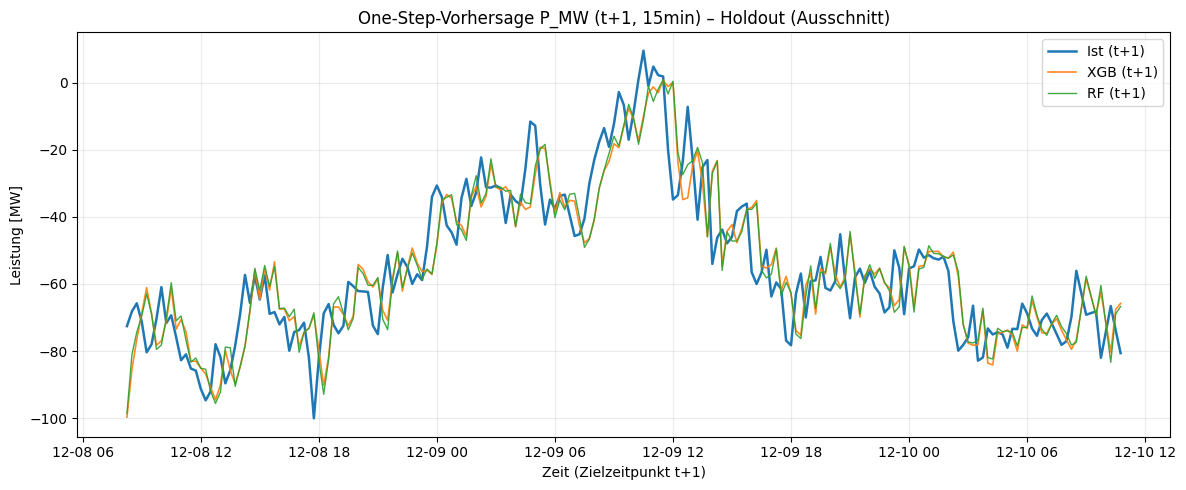


=== Zusammenfassung (Test/Holdout, t+1) ===
Baseline: {'MAE': 9.74040401467693, 'RMSE': 12.59837433807279, 'MAPE': np.float64(116.12662289556643), 'R2': 0.816914150718382}
RF   (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 9.60278838132388, 'RMSE': 12.353490366716898, 'MAPE': np.float64(138.99378369683825), 'R2': 0.8239625277712702}
XGB  (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 9.464323282503093, 'RMSE': 12.219134805111967, 'MAPE': np.float64(135.43634164090622), 'R2': 0.8277708436770632}

=== Trainingszeiten (ca.) ===
RF  (GridSearch + Fit): 366.3s
XGB (GridSearch + Fit): 23.2s

[XGB] Rekursiver Multi-Step-Forecast über 96 Schritte (24h)...

[Baseline] 96-Step-Ergebnis (24h-Naive: y[t-96])
BL 96-Step MAE:  24.6120
BL 96-Step RMSE: 32.8731
BL 96-Step MAPE: 57.45%
BL 96-Step R²:   -0.5246

[XGB] 96-Step-Ergebnis (rekursiv):
XGB 96-Step MAE:  16.9471
XGB 96-Step RMSE: 22.4797
XGB 96-

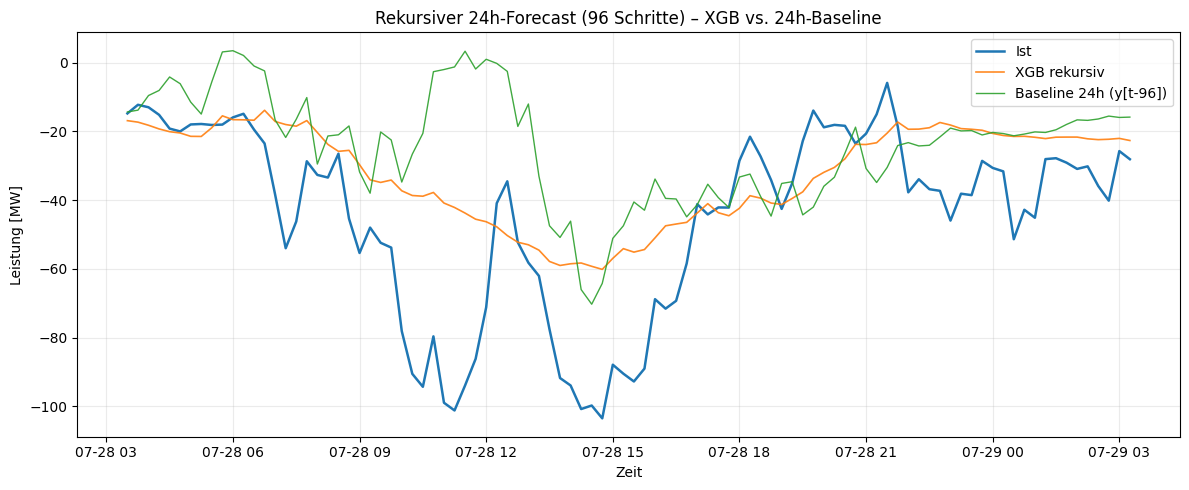

In [13]:
# -*- coding: utf-8 -*-
"""
One-Step-Forecast (t+1, 15 Minuten) + rekursiver 96-Step-Forecast
Modelle: RandomForest, XGBoost
Mit Hyperparameter-Tuning via GridSearchCV + TimeSeriesSplit

Benötigte Pakete:
    pip install pandas numpy scikit-learn matplotlib xgboost
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===================== USER SETTINGS =====================
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Wetter-/Exogene Features (müssen in der CSV existieren)
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (in 15-Min-Schritten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier-Saisonalität (Tagesperiodik, 24h = 96 * 15min)
FOURIER_K = 3
PERIOD_STEPS = 96

# Rekursiver Forecast-Horizont
HORIZON_STEPS = 96  # 24h = 96 * 15min

# Train/Test-Split
HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# =========================================================


# =========================================================
# Utility / Evaluation
# =========================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_rf, y_xgb, title="One-Step-Forecast (t+1, 15min)"):
    """Plot Ausschnitt des Holdouts (z.B. letzte 200 Punkte)."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (t+1)", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB (t+1)", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF (t+1)", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt t+1)")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_recursive(ts, y_true, y_pred_xgb, y_pred_bl, title="Rekursiver 96-Step-Forecast (24h)"):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.8)
    plt.plot(ts, y_pred_xgb, label="XGB rekursiv", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_pred_bl, label="Baseline 24h (y[t-96])", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================================================
# Feature Engineering
# =========================================================
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    if TARGET not in df.columns:
        raise KeyError(f"Zielspalte '{TARGET}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df


def add_time_features(df):
    ts = df[TIMESTAMP_COL]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    # zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


# =========================================================
# Baum-Modelle mit GridSearch
# =========================================================
def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t

    print(f"[{model_name}] Beste Parameter  : {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE     : {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit(s): {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (t+1) ")
    return scores, grid.best_params_, y_pred_test, dur, best_model


# =========================================================
# Rekursiver Forecast mit XGBoost (t+1 ... t+96)
# =========================================================
def recursive_forecast_xgb(
    model,
    df_model,
    feature_cols,
    target_col,
    start_row_idx,
    horizon_steps,
    target_lags,
):
    """
    Rekursiver Forecast:
    - model: trainierter XGBRegressor (t+1)
    - df_model: vollständiger Modell-DataFrame (mit Zeit-/Fourier-Features, aber Lags werden überschrieben)
    - feature_cols: verwendete Feature-Spalten
    - target_col: Name des Ziel-Columns (z.B. "P_MW")
    - start_row_idx: Index der ersten Feature-Zeile im Holdout (entspricht erstem One-Step-Punkt)
    - horizon_steps: Anzahl Vorwärtsschritte (z.B. 96)
    - target_lags: Liste der Lags in Schritten (z.B. [1,4,8,12,24,96])

    Für jedes Lag L gilt: target_lagL = history[-L], wobei history die letzten max_lag Werte enthält.
    """
    max_lag = max(target_lags)

    if start_row_idx - max_lag < 0:
        raise ValueError(
            f"start_row_idx={start_row_idx} ist zu klein für max_lag={max_lag}."
        )

    # Historie: letzte max_lag echte Zielwerte vor dem ersten Label-Zeitpunkt
    history = df_model[target_col].iloc[
        start_row_idx - max_lag + 1 : start_row_idx + 1
    ].tolist()
    if len(history) != max_lag:
        raise RuntimeError("History-Länge ungleich max_lag – Indexing-Problem.")

    preds = []
    label_indices = []

    for s in range(horizon_steps):
        row_idx = start_row_idx + s       # Feature-Zeile
        label_idx = row_idx + 1           # dazugehöriger Ziel-Zeitpunkt

        if label_idx >= len(df_model):
            break

        row = df_model.iloc[row_idx].copy()

        # Lag-Features aus aktueller Historie neu setzen
        for L in target_lags:
            row[f"{target_col}_lag{L}"] = history[-L]

        x_vec = row[feature_cols].values.reshape(1, -1)
        y_hat = model.predict(x_vec)[0]

        preds.append(y_hat)
        label_indices.append(label_idx)

        # History aktualisieren
        history.append(y_hat)
        if len(history) > max_lag:
            history = history[-max_lag:]

    return np.array(preds), np.array(label_indices)


# =========================================================
# MAIN
# =========================================================
def main():
    print("Lade Daten...")
    df = load_data(CSV_PATH)

    # ========== Feature Engineering ==========
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # Ziel: t+1 (ein Schritt = 15 Minuten)
    df["target_1"] = df[TARGET].shift(-1)

    # Verfügbare exogene Features prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing_feats = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing_feats:
        print(f"Warnung: folgende RAW_FEATURES fehlen und werden ignoriert: {missing_feats}")

    time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{TARGET}_lag{l}" for l in TARGET_LAGS]

    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    # NaNs entfernen (wegen Shifts)
    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()

    X = df_model[feature_cols]
    y = df_model["target_1"]

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test: {len(X_test)}")
    print("Vorhersagehorizont: t+1 (15 Minuten)")

    # ========== Baseline (Naive Persistence: y_hat_{t+1} = y_t) ==========
    print("\nBaseline (Naive One-Step-Persistence) – Scores:")
    y_baseline_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    y_baseline_test = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values

    _ = evaluate(y_train.values, y_baseline_train, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_baseline_test, prefix="BL  (Test)  ")

    # ========== Random Forest ==========
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time, rf_model = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== XGBoost ==========
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time, xgb_model = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== Plot – One-Step Holdout-Ausschnitt ==========
    n_plot = 200
    if len(y_test) <= n_plot:
        start_idx_plot = 0
    else:
        start_idx_plot = len(y_test) - n_plot

    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(
        ts_holdout.iloc[start_idx_plot:],
        y_test.values[start_idx_plot:],
        rf_pred[start_idx_plot:],
        xgb_pred[start_idx_plot:],
        title=f"One-Step-Vorhersage {TARGET} (t+1, 15min) – Holdout (Ausschnitt)"
    )

    print("\n=== Zusammenfassung (Test/Holdout, t+1) ===")
    print("Baseline:", bl_scores)
    print(f"RF   (best_params={rf_best_params}):", rf_scores)
    print(f"XGB  (best_params={xgb_best_params}):", xgb_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF  (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB (GridSearch + Fit): {xgb_time:.1f}s")

    # ========== Rekursiver 96-Step-Forecast mit XGB ==========
    print(f"\n[XGB] Rekursiver Multi-Step-Forecast über {HORIZON_STEPS} Schritte (24h)...")

    start_row_idx = split_idx

    horizon = min(
        HORIZON_STEPS,
        len(df_model) - (start_row_idx + 1)
    )

    y_xgb_multi, label_indices = recursive_forecast_xgb(
        model=xgb_model,
        df_model=df_model,
        feature_cols=feature_cols,
        target_col=TARGET,
        start_row_idx=start_row_idx,
        horizon_steps=horizon,
        target_lags=TARGET_LAGS,
    )

    # True-Werte für die Zielzeitpunkte
    y_true_multi = df_model[TARGET].iloc[label_indices].values
    ts_multi = df_model[TIMESTAMP_COL].iloc[label_indices]

    # ===== 24h-Baseline für Multi-Step: y_hat(t) = y(t-96) =====
    # (setzt voraus, dass label_indices >= PERIOD_STEPS, was bei deinem Split gegeben ist)
    target_arr = df_model[TARGET].values
    baseline_indices = label_indices - PERIOD_STEPS
    if (baseline_indices < 0).any():
        raise RuntimeError("Für einige Zielzeitpunkte existiert keine 24h-Historie (t-96).")

    y_bl_multi = target_arr[baseline_indices]

    print("\n[Baseline] 96-Step-Ergebnis (24h-Naive: y[t-96])")
    bl_multi_scores = evaluate(y_true_multi, y_bl_multi, prefix="BL 96-Step ")

    print("\n[XGB] 96-Step-Ergebnis (rekursiv):")
    multi_scores = evaluate(y_true_multi, y_xgb_multi, prefix="XGB 96-Step ")

    # Plot der rekursiven 24h-Vorhersage vs. Baseline
    plot_recursive(
        ts_multi,
        y_true_multi,
        y_xgb_multi,
        y_bl_multi,
        title=f"Rekursiver 24h-Forecast (96 Schritte) – XGB vs. 24h-Baseline"
    )


if __name__ == "__main__":
    main()


Lade Daten...

=== Cleaning: Ausgangslage ===
Zeilen vor Cleaning: 68116
P_MW: min=-195.637, max=142.891
Quantile vor Cleaning (0.1%, 1%, 99%, 99.9%):
0.001   -151.726231
0.010   -119.238984
0.990      7.648999
0.999     21.496507
Name: P_MW, dtype: float64

=== Cleaning: nachher ===
Zeilen nach Cleaning : 65745 (−0 entfernt)
P_MW (clean): min=-151.731, max=21.497
Quantile nach Cleaning (0.1%, 1%, 99%, 99.9%):
0.001   -151.521295
0.010   -119.240285
0.990      7.649094
0.999     21.465923
Name: P_MW, dtype: float64
Entfernte extreme Sprünge |ΔP| > 150 MW: 0
Datengrößen – Gesamt: 65648, Train: 52518, Test: 13130
Vorhersagehorizont: t+1 (15 Minuten)

Baseline (Naive One-Step-Persistence) – Scores:
BL  (Train) MAE:  5.7365
BL  (Train) RMSE: 9.4983
BL  (Train) MAPE: 45,496.92%
BL  (Train) R²:   0.8927
BL  (Test)  MAE:  9.7175
BL  (Test)  RMSE: 12.5840
BL  (Test)  MAPE: 114.99%
BL  (Test)  R²:   0.8162

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, tota

/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[RF] Beste Parameter  : {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE     : 6.1190
[RF] GridSearch+Fit(s): 403.5s
RF TST (t+1) MAE:  9.5997
RF TST (t+1) RMSE: 12.3554
RF TST (t+1) MAPE: 137.52%
RF TST (t+1) R²:   0.8229

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter  : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE     : 6.2249
[XGB] GridSearch+Fit(s): 21.9s
XGB TST (t+1) MAE:  9.4918
XGB TST (t+1) RMSE: 12.2481
XGB TST (t+1) MAPE: 133.86%
XGB TST (t+1) R²:   0.8259


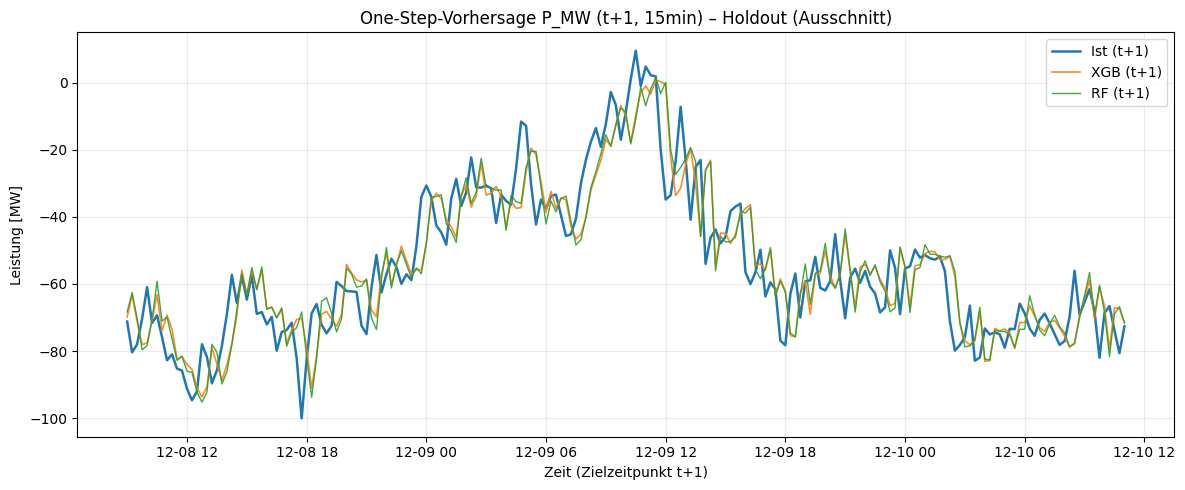


=== Zusammenfassung (Test/Holdout, t+1) ===
Baseline: {'MAE': 9.717466065100894, 'RMSE': 12.584017864622911, 'MAPE': np.float64(114.98900327800123), 'R2': 0.8162399879432058}
RF   (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 9.599707546639586, 'RMSE': 12.35544397142444, 'MAPE': np.float64(137.51982231540524), 'R2': 0.822854930262009}
XGB  (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 9.491792280952303, 'RMSE': 12.248067344148572, 'MAPE': np.float64(133.85701797425259), 'R2': 0.8259205565339018}

=== Trainingszeiten (ca.) ===
RF  (GridSearch + Fit): 403.5s
XGB (GridSearch + Fit): 21.9s

[XGB] Rekursiver Multi-Step-Forecast über 96 Schritte (24h)...

[XGB] 96-Step-Ergebnis (rekursiv):
XGB 96-Step MAE:  7.7516
XGB 96-Step RMSE: 9.6148
XGB 96-Step MAPE: 103.88%
XGB 96-Step R²:   0.5308


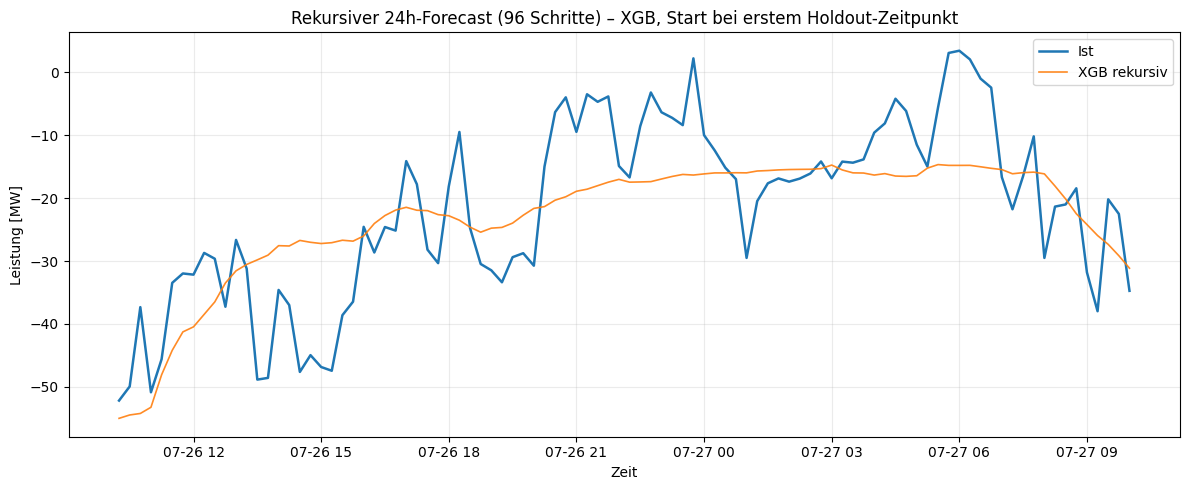

In [15]:
# 96 steps recursive forecast mit cleaning procedure
# -*- coding: utf-8 -*-
"""
One-Step-Forecast (t+1, 15 Minuten) + rekursiver 96-Step-Forecast
Modelle: RandomForest, XGBoost
Mit Hyperparameter-Tuning via GridSearchCV + TimeSeriesSplit

Benötigte Pakete:
    pip install pandas numpy scikit-learn matplotlib xgboost
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===================== USER SETTINGS =====================
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Wetter-/Exogene Features (müssen in der CSV existieren)
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (in 15-Min-Schritten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier-Saisonalität (Tagesperiodik, 24h = 96 * 15min)
FOURIER_K = 3
PERIOD_STEPS = 96

# Rekursiver Forecast-Horizont
HORIZON_STEPS = 96  # 24h = 96 * 15min

# Train/Test-Split
HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# =========================================================


# =========================================================
# Utility / Evaluation
# =========================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_rf, y_xgb, title="One-Step-Forecast (t+1, 15min)"):
    """Plot Ausschnitt des Holdouts (z.B. letzte 200 Punkte)."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (t+1)", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB (t+1)", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF (t+1)", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt t+1)")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_recursive(ts, y_true, y_pred, title="Rekursiver 96-Step-Forecast (24h)"):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.8)
    plt.plot(ts, y_pred, label="XGB rekursiv", linewidth=1.2, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================================================
# Feature Engineering
# =========================================================
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    if TARGET not in df.columns:
        raise KeyError(f"Zielspalte '{TARGET}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df


def add_time_features(df):
    ts = df[TIMESTAMP_COL]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    # zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


# =========================================================
# Cleaning-Pipeline (NEU)
# =========================================================
def clean_data(df):
    """
    Einfache Cleaning-Pipeline, um offensichtliche Probleme zu entschärfen:
      - Entfernt Zeilen mit NaNs in TARGET oder vorhandenen RAW_FEATURES
      - Clipped P_MW auf [q0.001, q0.999] (Winsorizing)
      - Entfernt Zeilen mit extremen Sprüngen |ΔP| > 150 MW
    Alles rein experimentell, um zu sehen, wie stark sich das auf das Scoring auswirkt.
    """

    print("\n=== Cleaning: Ausgangslage ===")
    print(f"Zeilen vor Cleaning: {len(df)}")
    print(f"P_MW: min={df[TARGET].min():.3f}, max={df[TARGET].max():.3f}")
    q_before = df[TARGET].quantile([0.001, 0.01, 0.99, 0.999])
    print("Quantile vor Cleaning (0.1%, 1%, 99%, 99.9%):")
    print(q_before)

    # 1) NaNs in Ziel und verfügbaren Wetterspalten entfernen
    nan_cols = [TARGET] + [c for c in RAW_FEATURES if c in df.columns]
    df = df.dropna(subset=nan_cols).copy()

    # 2) Extremwerte in P_MW winsorizen (abschneiden)
    q_low, q_high = df[TARGET].quantile([0.001, 0.999])
    df[TARGET] = df[TARGET].clip(lower=q_low, upper=q_high)

    # 3) Extreme Sprünge (Delta) entfernen (optional, sehr konservativ)
    df["P_diff"] = df[TARGET].diff()
    jump_mask = df["P_diff"].abs() > 150  # Schwelle anpassbar
    removed_jumps = jump_mask.sum()
    df = df.loc[~jump_mask].copy()
    df = df.drop(columns=["P_diff"])

    print("\n=== Cleaning: nachher ===")
    print(f"Zeilen nach Cleaning : {len(df)} (−{len(df) - len(df)} entfernt)")
    print(f"P_MW (clean): min={df[TARGET].min():.3f}, max={df[TARGET].max():.3f}")
    q_after = df[TARGET].quantile([0.001, 0.01, 0.99, 0.999])
    print("Quantile nach Cleaning (0.1%, 1%, 99%, 99.9%):")
    print(q_after)
    print(f"Entfernte extreme Sprünge |ΔP| > 150 MW: {removed_jumps}")

    return df


# =========================================================
# Baum-Modelle mit GridSearch
# =========================================================
def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t

    print(f"[{model_name}] Beste Parameter  : {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE     : {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit(s): {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (t+1) ")
    return scores, grid.best_params_, y_pred_test, dur, best_model


# =========================================================
# Rekursiver Forecast mit XGBoost (t+1 ... t+96)
# =========================================================
def recursive_forecast_xgb(
    model,
    df_model,
    feature_cols,
    target_col,
    start_row_idx,
    horizon_steps,
    target_lags,
):
    """
    Rekursiver Forecast:
    - model: trainierter XGBRegressor (t+1)
    - df_model: vollständiger Modell-DataFrame (mit Zeit-/Fourier-Features, aber Lags werden überschrieben)
    - feature_cols: verwendete Feature-Spalten
    - target_col: Name des Ziel-Columns (z.B. "P_MW")
    - start_row_idx: Index der ersten Feature-Zeile im Holdout (entspricht erstem One-Step-Punkt)
    - horizon_steps: Anzahl Vorwärtsschritte (z.B. 96)
    - target_lags: Liste der Lags in Schritten (z.B. [1,4,8,12,24,96])
    """
    max_lag = max(target_lags)

    if start_row_idx - max_lag < 0:
        raise ValueError(
            f"start_row_idx={start_row_idx} ist zu klein für max_lag={max_lag}."
        )

    history = df_model[target_col].iloc[
        start_row_idx - max_lag + 1 : start_row_idx + 1
    ].tolist()
    if len(history) != max_lag:
        raise RuntimeError("History-Länge ungleich max_lag – Indexing-Problem.")

    preds = []
    label_indices = []

    for s in range(horizon_steps):
        row_idx = start_row_idx + s
        label_idx = row_idx + 1

        if label_idx >= len(df_model):
            break

        row = df_model.iloc[row_idx].copy()

        for L in target_lags:
            row[f"{target_col}_lag{L}"] = history[-L]

        x_vec = row[feature_cols].values.reshape(1, -1)
        y_hat = model.predict(x_vec)[0]

        preds.append(y_hat)
        label_indices.append(label_idx)

        history.append(y_hat)
        if len(history) > max_lag:
            history = history[-max_lag:]

    return np.array(preds), np.array(label_indices)


# =========================================================
# MAIN
# =========================================================
def main():
    print("Lade Daten...")
    df = load_data(CSV_PATH)

    # >>>>>>>>>>>>>> NEU: Cleaning-Pipeline einfügen <<<<<<<<<<<<<<
    df = clean_data(df)
    # >>>>>>>>>>>>>> Ende Cleaning <<<<<<<<<<<<<<

    # ========== Feature Engineering ==========
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # Ziel: t+1 (ein Schritt = 15 Minuten)
    df["target_1"] = df[TARGET].shift(-1)

    # Verfügbare exogene Features prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing_feats = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing_feats:
        print(f"Warnung: folgende RAW_FEATURES fehlen und werden ignoriert: {missing_feats}")

    time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{TARGET}_lag{l}" for l in TARGET_LAGS]

    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    # NaNs entfernen (wegen Shifts)
    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()

    X = df_model[feature_cols]
    y = df_model["target_1"]

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test: {len(X_test)}")
    print("Vorhersagehorizont: t+1 (15 Minuten)")

    # ========== Baseline (Naive Persistence: y_hat_{t+1} = y_t) ==========
    print("\nBaseline (Naive One-Step-Persistence) – Scores:")
    y_baseline_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    y_baseline_test = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values

    _ = evaluate(y_train.values, y_baseline_train, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_baseline_test, prefix="BL  (Test)  ")

    # ========== Random Forest ==========
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time, rf_model = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== XGBoost ==========
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time, xgb_model = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== Plot – One-Step Holdout-Ausschnitt ==========
    n_plot = 200
    if len(y_test) <= n_plot:
        start_idx_plot = 0
    else:
        start_idx_plot = len(y_test) - n_plot

    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(
        ts_holdout.iloc[start_idx_plot:],
        y_test.values[start_idx_plot:],
        rf_pred[start_idx_plot:],
        xgb_pred[start_idx_plot:],
        title=f"One-Step-Vorhersage {TARGET} (t+1, 15min) – Holdout (Ausschnitt)"
    )

    print("\n=== Zusammenfassung (Test/Holdout, t+1) ===")
    print("Baseline:", bl_scores)
    print(f"RF   (best_params={rf_best_params}):", rf_scores)
    print(f"XGB  (best_params={xgb_best_params}):", xgb_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF  (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB (GridSearch + Fit): {xgb_time:.1f}s")

    # ========== Rekursiver 96-Step-Forecast mit XGB ==========
    print(f"\n[XGB] Rekursiver Multi-Step-Forecast über {HORIZON_STEPS} Schritte (24h)...")

    start_row_idx = split_idx
    horizon = min(
        HORIZON_STEPS,
        len(df_model) - (start_row_idx + 1)
    )

    y_xgb_multi, label_indices = recursive_forecast_xgb(
        model=xgb_model,
        df_model=df_model,
        feature_cols=feature_cols,
        target_col=TARGET,
        start_row_idx=start_row_idx,
        horizon_steps=horizon,
        target_lags=TARGET_LAGS,
    )

    y_true_multi = df_model[TARGET].iloc[label_indices].values
    ts_multi = df_model[TIMESTAMP_COL].iloc[label_indices]

    print("\n[XGB] 96-Step-Ergebnis (rekursiv):")
    multi_scores = evaluate(y_true_multi, y_xgb_multi, prefix="XGB 96-Step ")

    plot_recursive(
        ts_multi,
        y_true_multi,
        y_xgb_multi,
        title=f"Rekursiver 24h-Forecast (96 Schritte) – XGB, Start bei erstem Holdout-Zeitpunkt"
    )


if __name__ == "__main__":
    main()


Lade Daten...

=== Cleaning: Ausgangslage ===
Zeilen vor Cleaning: 68116
P_MW: min=-195.637, max=142.891
Quantile vor Cleaning (0.1%, 1%, 99%, 99.9%):
0.001   -151.726231
0.010   -119.238984
0.990      7.648999
0.999     21.496507
Name: P_MW, dtype: float64

=== Cleaning: nachher ===
Zeilen nach Cleaning : 65745 (−2371 entfernt)
P_MW (clean): min=-151.731, max=21.497
Quantile nach Cleaning (0.1%, 1%, 99%, 99.9%):
0.001   -151.521295
0.010   -119.240285
0.990      7.649094
0.999     21.465923
Name: P_MW, dtype: float64
Entfernte extreme Sprünge |ΔP| > 150 MW: 0
Datengrößen – Gesamt: 65648, Train: 52518, Test: 13130
Vorhersagehorizont: t+1 (15 Minuten)

Baseline (Naive One-Step-Persistence) – Scores:
BL  (Train) MAE:  5.7365
BL  (Train) RMSE: 9.4983
BL  (Train) MAPE: 45,496.92%
BL  (Train) R²:   0.8927
BL  (Test)  MAE:  9.7175
BL  (Test)  RMSE: 12.5840
BL  (Test)  MAPE: 114.99%
BL  (Test)  R²:   0.8162

[RF] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 8 candidates, t

/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[RF] Beste Parameter  : {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE     : 6.1190
[RF] GridSearch+Fit(s): 350.4s
RF TST (t+1) MAE:  9.5997
RF TST (t+1) RMSE: 12.3554
RF TST (t+1) MAPE: 137.52%
RF TST (t+1) R²:   0.8229

[XGB] Hyperparameter-Suche (GridSearch)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter  : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE     : 6.2249
[XGB] GridSearch+Fit(s): 18.4s
XGB TST (t+1) MAE:  9.4918
XGB TST (t+1) RMSE: 12.2481
XGB TST (t+1) MAPE: 133.86%
XGB TST (t+1) R²:   0.8259


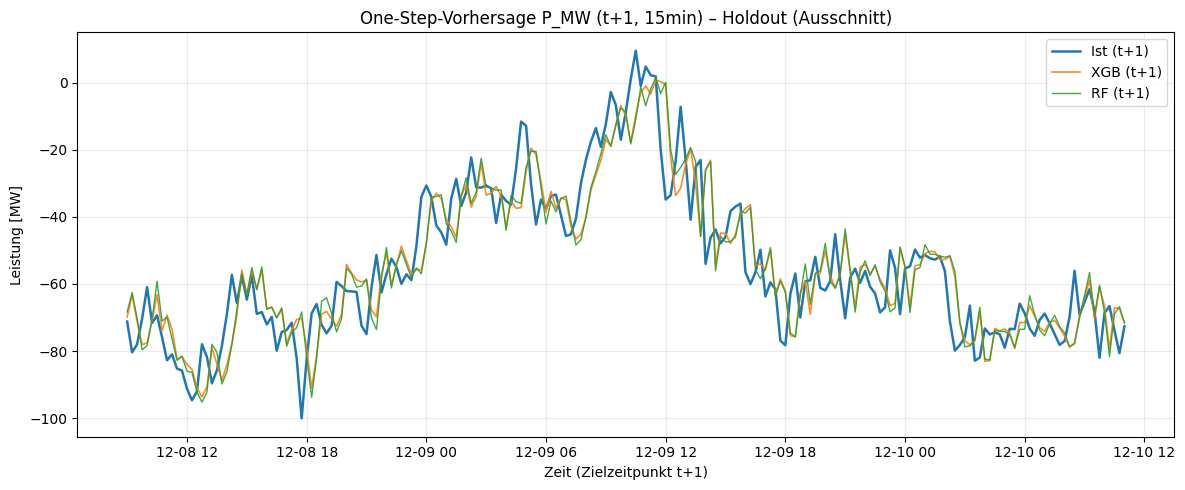


=== Zusammenfassung (Test/Holdout, t+1) ===
Baseline: {'MAE': 9.717466065100894, 'RMSE': 12.584017864622911, 'MAPE': np.float64(114.98900327800123), 'R2': 0.8162399879432058}
RF   (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 9.599707546639586, 'RMSE': 12.35544397142444, 'MAPE': np.float64(137.51982231540526), 'R2': 0.822854930262009}
XGB  (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 9.491792280952303, 'RMSE': 12.248067344148572, 'MAPE': np.float64(133.85701797425259), 'R2': 0.8259205565339018}

=== Trainingszeiten (ca.) ===
RF  (GridSearch + Fit): 350.4s
XGB (GridSearch + Fit): 18.4s

[RF/XGB] Rekursiver Multi-Step-Forecast über 96 Schritte (24h)...


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature name


[Baseline] 96-Step-Ergebnis (24h-Naive: y[t-96])
BL  96-Step MAE:  15.1718
BL  96-Step RMSE: 19.2298
BL  96-Step MAPE: 180.58%
BL  96-Step R²:   -0.8767

[RF] 96-Step-Ergebnis (rekursiv):
RF  96-Step MAE:  13.2013
RF  96-Step RMSE: 15.8486
RF  96-Step MAPE: 207.10%
RF  96-Step R²:   -0.2748

[XGB] 96-Step-Ergebnis (rekursiv):
XGB 96-Step MAE:  7.7516
XGB 96-Step RMSE: 9.6148
XGB 96-Step MAPE: 103.88%
XGB 96-Step R²:   0.5308


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature name

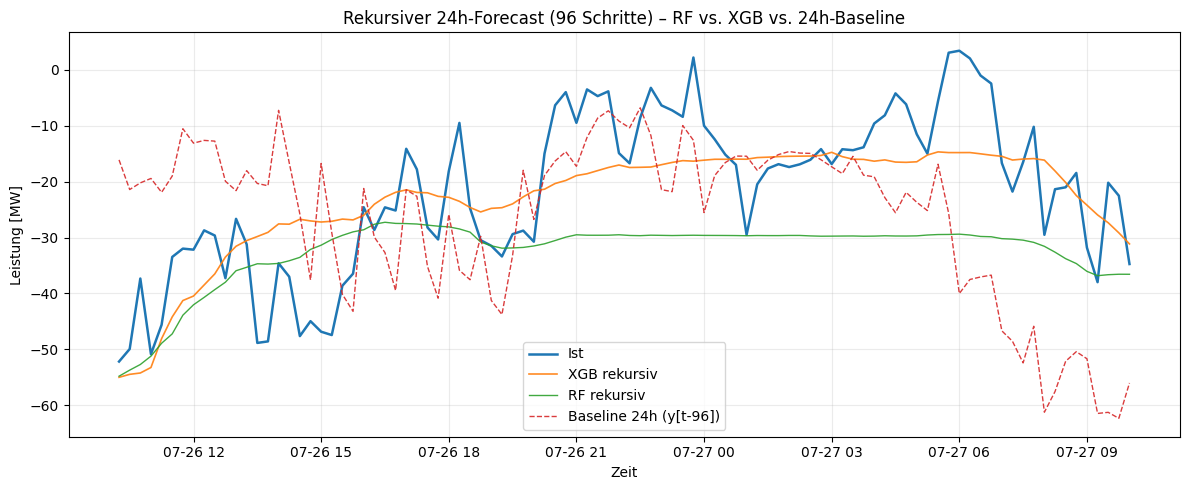

In [16]:
# 96 steps recursive forecast mit cleaning procedure
# -*- coding: utf-8 -*-
"""
One-Step-Forecast (t+1, 15 Minuten) + rekursiver 96-Step-Forecast
Modelle: RandomForest, XGBoost
Mit Hyperparameter-Tuning via GridSearchCV + TimeSeriesSplit

Benötigte Pakete:
    pip install pandas numpy scikit-learn matplotlib xgboost
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ===================== USER SETTINGS =====================
CSV_PATH = r"src/data/raw/timeseries/SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
TARGET = "P_MW"

# Wetter-/Exogene Features (müssen in der CSV existieren)
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (in 15-Min-Schritten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]

# Fourier-Saisonalität (Tagesperiodik, 24h = 96 * 15min)
FOURIER_K = 3
PERIOD_STEPS = 96

# Rekursiver Forecast-Horizont
HORIZON_STEPS = 96  # 24h = 96 * 15min

# Train/Test-Split
HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42
# =========================================================


# =========================================================
# Utility / Evaluation
# =========================================================
def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_rf, y_xgb, title="One-Step-Forecast (t+1, 15min)"):
    """Plot Ausschnitt des Holdouts (z.B. letzte 200 Punkte)."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (t+1)", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB (t+1)", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF (t+1)", linewidth=1.0, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt t+1)")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_recursive(ts, y_true, y_rf, y_xgb, y_bl, title="Rekursiver 96-Step-Forecast (24h)"):
    """Plot für 24h-Forecast: Ist vs RF vs XGB vs Baseline."""
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.8)
    plt.plot(ts, y_xgb, label="XGB rekursiv", linewidth=1.2, alpha=0.9)
    plt.plot(ts, y_rf, label="RF rekursiv", linewidth=1.0, alpha=0.9)
    plt.plot(ts, y_bl, label="Baseline 24h (y[t-96])", linewidth=1.0, linestyle="--", alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [MW]")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================================================
# Feature Engineering
# =========================================================
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)
    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")
    if TARGET not in df.columns:
        raise KeyError(f"Zielspalte '{TARGET}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df


def add_time_features(df):
    ts = df[TIMESTAMP_COL]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month

    # zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps=PERIOD_STEPS, K=FOURIER_K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


# =========================================================
# Cleaning-Pipeline
# =========================================================
def clean_data(df):
    """
    Einfache Cleaning-Pipeline:
      - entfernt NaNs in TARGET / RAW_FEATURES
      - clippt P_MW auf [q0.001, q0.999]
      - entfernt Zeilen mit extremen Sprüngen |ΔP| > 150 MW
    """

    print("\n=== Cleaning: Ausgangslage ===")
    print(f"Zeilen vor Cleaning: {len(df)}")
    print(f"P_MW: min={df[TARGET].min():.3f}, max={df[TARGET].max():.3f}")
    q_before = df[TARGET].quantile([0.001, 0.01, 0.99, 0.999])
    print("Quantile vor Cleaning (0.1%, 1%, 99%, 99.9%):")
    print(q_before)

    n_before = len(df)

    # 1) NaNs in Ziel und verfügbaren Wetterspalten entfernen
    nan_cols = [TARGET] + [c for c in RAW_FEATURES if c in df.columns]
    df = df.dropna(subset=nan_cols).copy()

    # 2) Extremwerte in P_MW winsorizen (abschneiden)
    q_low, q_high = df[TARGET].quantile([0.001, 0.999])
    df[TARGET] = df[TARGET].clip(lower=q_low, upper=q_high)

    # 3) Extreme Sprünge (Delta) entfernen
    df["P_diff"] = df[TARGET].diff()
    jump_mask = df["P_diff"].abs() > 150
    removed_jumps = jump_mask.sum()
    df = df.loc[~jump_mask].copy()
    df = df.drop(columns=["P_diff"])

    print("\n=== Cleaning: nachher ===")
    print(f"Zeilen nach Cleaning : {len(df)} (−{n_before - len(df)} entfernt)")
    print(f"P_MW (clean): min={df[TARGET].min():.3f}, max={df[TARGET].max():.3f}")
    q_after = df[TARGET].quantile([0.001, 0.01, 0.99, 0.999])
    print("Quantile nach Cleaning (0.1%, 1%, 99%, 99.9%):")
    print(q_after)
    print(f"Entfernte extreme Sprünge |ΔP| > 150 MW: {removed_jumps}")

    return df


# =========================================================
# Baum-Modelle mit GridSearch
# =========================================================
def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t

    print(f"[{model_name}] Beste Parameter  : {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE     : {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit(s): {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (t+1) ")
    return scores, grid.best_params_, y_pred_test, dur, best_model


# =========================================================
# Rekursiver Forecast (generisch für RF & XGB)
# =========================================================
def recursive_forecast_model(
    model,
    df_model,
    feature_cols,
    target_col,
    start_row_idx,
    horizon_steps,
    target_lags,
):
    """
    Generischer rekursiver Multi-Step-Forecast mit einem beliebigen Regressor (RF/XGB).
    - model: trainierter Regressor (t+1)
    - df_model: DataFrame mit Zeit-/Fourier-/exogenen Features + (initialen) Lag-Spalten
    - feature_cols: Feature-Spalten, die an model.predict() gehen
    - target_col: Name der Zielspalte (z.B. "P_MW")
    - start_row_idx: Index der ersten Feature-Zeile im Holdout (entspricht erstem One-Step-Punkt)
    - horizon_steps: Anzahl Vorwärtsschritte (z.B. 96)
    - target_lags: Liste der Lags in Schritten (z.B. [1,4,8,12,24,96])
    """
    max_lag = max(target_lags)

    if start_row_idx - max_lag < 0:
        raise ValueError(
            f"start_row_idx={start_row_idx} ist zu klein für max_lag={max_lag}."
        )

    # Historie: letzte max_lag echte Zielwerte vor dem ersten Label-Zeitpunkt
    history = df_model[target_col].iloc[
        start_row_idx - max_lag + 1 : start_row_idx + 1
    ].tolist()
    if len(history) != max_lag:
        raise RuntimeError("History-Länge ungleich max_lag – Indexing-Problem.")

    preds = []
    label_indices = []

    for s in range(horizon_steps):
        row_idx = start_row_idx + s       # Feature-Zeile
        label_idx = row_idx + 1           # Zielzeitpunkt

        if label_idx >= len(df_model):
            break

        row = df_model.iloc[row_idx].copy()

        # Lag-Features aus aktueller Historie neu setzen
        for L in target_lags:
            row[f"{target_col}_lag{L}"] = history[-L]

        x_vec = row[feature_cols].values.reshape(1, -1)
        y_hat = model.predict(x_vec)[0]

        preds.append(y_hat)
        label_indices.append(label_idx)

        history.append(y_hat)
        if len(history) > max_lag:
            history = history[-max_lag:]

    return np.array(preds), np.array(label_indices)


# =========================================================
# MAIN
# =========================================================
def main():
    print("Lade Daten...")
    df = load_data(CSV_PATH)

    # Cleaning
    df = clean_data(df)

    # ========== Feature Engineering ==========
    df = add_time_features(df)
    df = add_fourier_features(df)
    df = add_target_lags(df, TARGET, TARGET_LAGS)

    # Ziel: t+1 (ein Schritt = 15 Minuten)
    df["target_1"] = df[TARGET].shift(-1)

    # Verfügbare exogene Features prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing_feats = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing_feats:
        print(f"Warnung: folgende RAW_FEATURES fehlen und werden ignoriert: {missing_feats}")

    time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{TARGET}_lag{l}" for l in TARGET_LAGS]

    feature_cols = present_feats + time_feats + fourier_feats + lag_feats

    # NaNs entfernen (wegen Shifts)
    df_model = df.dropna(subset=feature_cols + ["target_1"]).copy()

    X = df_model[feature_cols]
    y = df_model["target_1"]

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test: {len(X_test)}")
    print("Vorhersagehorizont: t+1 (15 Minuten)")

    # ========== Baseline (Naive Persistence: y_hat_{t+1} = y_t) ==========
    print("\nBaseline (Naive One-Step-Persistence) – Scores:")
    y_baseline_train = df_model[f"{TARGET}_lag1"].iloc[:split_idx].values
    y_baseline_test = df_model[f"{TARGET}_lag1"].iloc[split_idx:].values

    _ = evaluate(y_train.values, y_baseline_train, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_baseline_test, prefix="BL  (Test)  ")

    # ========== Random Forest ==========
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time, rf_model = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== XGBoost ==========
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time, xgb_model = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ========== Plot – One-Step Holdout-Ausschnitt ==========
    n_plot = 200
    if len(y_test) <= n_plot:
        start_idx_plot = 0
    else:
        start_idx_plot = len(y_test) - n_plot

    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(
        ts_holdout.iloc[start_idx_plot:],
        y_test.values[start_idx_plot:],
        rf_pred[start_idx_plot:],
        xgb_pred[start_idx_plot:],
        title=f"One-Step-Vorhersage {TARGET} (t+1, 15min) – Holdout (Ausschnitt)"
    )

    print("\n=== Zusammenfassung (Test/Holdout, t+1) ===")
    print("Baseline:", bl_scores)
    print(f"RF   (best_params={rf_best_params}):", rf_scores)
    print(f"XGB  (best_params={xgb_best_params}):", xgb_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF  (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB (GridSearch + Fit): {xgb_time:.1f}s")

    # ========== Rekursiver 96-Step-Forecast mit RF & XGB + 24h-Baseline ==========
    print(f"\n[RF/XGB] Rekursiver Multi-Step-Forecast über {HORIZON_STEPS} Schritte (24h)...")

    start_row_idx = split_idx
    horizon = min(
        HORIZON_STEPS,
        len(df_model) - (start_row_idx + 1)
    )

    # XGB rekursiv
    y_xgb_multi, label_indices = recursive_forecast_model(
        model=xgb_model,
        df_model=df_model,
        feature_cols=feature_cols,
        target_col=TARGET,
        start_row_idx=start_row_idx,
        horizon_steps=horizon,
        target_lags=TARGET_LAGS,
    )

    # RF rekursiv – gleicher Start/Horizon → gleiche label_indices
    y_rf_multi, label_indices_rf = recursive_forecast_model(
        model=rf_model,
        df_model=df_model,
        feature_cols=feature_cols,
        target_col=TARGET,
        start_row_idx=start_row_idx,
        horizon_steps=horizon,
        target_lags=TARGET_LAGS,
    )

    # Sicherheitscheck (sollten identisch sein)
    assert np.array_equal(label_indices, label_indices_rf)

    # True-Werte und Timestamps
    y_true_multi = df_model[TARGET].iloc[label_indices].values
    ts_multi = df_model[TIMESTAMP_COL].iloc[label_indices]

    # 24h-Baseline: y_hat(t) = y(t-96)
    target_arr = df_model[TARGET].values
    baseline_indices = label_indices - PERIOD_STEPS
    if (baseline_indices < 0).any():
        raise RuntimeError("Für einige Zielzeitpunkte existiert keine 24h-Historie (t-96).")

    y_bl_multi = target_arr[baseline_indices]

    print("\n[Baseline] 96-Step-Ergebnis (24h-Naive: y[t-96])")
    bl_multi_scores = evaluate(y_true_multi, y_bl_multi, prefix="BL  96-Step ")

    print("\n[RF] 96-Step-Ergebnis (rekursiv):")
    rf_multi_scores = evaluate(y_true_multi, y_rf_multi, prefix="RF  96-Step ")

    print("\n[XGB] 96-Step-Ergebnis (rekursiv):")
    xgb_multi_scores = evaluate(y_true_multi, y_xgb_multi, prefix="XGB 96-Step ")

    # Plot der rekursiven 24h-Vorhersage vs. Baseline
    plot_recursive(
        ts_multi,
        y_true_multi,
        y_rf_multi,
        y_xgb_multi,
        y_bl_multi,
        title=f"Rekursiver 24h-Forecast (96 Schritte) – RF vs. XGB vs. 24h-Baseline"
    )


if __name__ == "__main__":
    main()
